In [1]:
!pip install transformers datasets

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import nltk
import re


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\Craib-Lab\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\Craib-Lab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Craib-
[nltk_data]     Lab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Paths to datasets
d_path = "d_tweets.csv"
non_d_path = "non_d_tweets.csv"

# Load datasets
d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Remove empty rows
d_tweet_df = d_tweet_df[d_tweet_df['tweet'].notna()]
non_d_tweet_df = non_d_tweet_df[non_d_tweet_df['tweet'].notna()]

# Assign labels
d_tweet_df['label'] = 1
non_d_tweet_df['label'] = 0

# Combine and shuffle datasets
tweet_df = pd.concat([d_tweet_df[['tweet', 'label']], non_d_tweet_df[['tweet', 'label']]])
tweet_df = tweet_df.sample(frac=1).reset_index(drop=True)

# Undersample the majority class
majority_class = tweet_df[tweet_df['label'] == 0]
minority_class = tweet_df[tweet_df['label'] == 1]
majority_undersampled = resample(
    majority_class, replace=False, n_samples=len(minority_class), random_state=42
)
tweet_df = pd.concat([majority_undersampled, minority_class])
tweet_df = shuffle(tweet_df).reset_index(drop=True)

In [4]:
print(tweet_df)

                                                  tweet  label
0     When we care less about our people, our people...      0
1     By popular demand, I will not be releasing the...      0
2     But I can't sleep because that thought just ke...      1
3      If you've bothered, you would have seen my pain.      1
4     The first 5 mins of this pod with @Jason and @...      0
...                                                 ...    ...
6987  I used to think "billionaires going to space" ...      0
6988  i’m ashamed of myself because i know i should ...      1
6989   https://t.co/BiZj6qXu8h  thank you @EmmaSpect...      1
6990  I am packing on weight for a movie role I don’...      0
6991             i wish i was a bagel with cream cheese      1

[6992 rows x 2 columns]


In [5]:
# Preprocess text function
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove user mentions
    text = re.sub(r"[^A-Za-z\s]", '', text)  # Remove special characters and digits
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

In [6]:
# Apply preprocessing
tweet_df['tweet'] = tweet_df['tweet'].apply(preprocess_text)

In [7]:
print(tweet_df['tweet'].head(10))


0    when we care less about our people our people ...
1    by popular demand i will not be releasing the ...
2    but i cant sleep because that thought just kee...
3        if youve bothered you would have seen my pain
4                the first  mins of this pod with  and
5                         do thoughts and prayers work
6    just do what you do and do it well stop worryi...
7                  you need to understand but you dont
8                                         overthinking
9    as soon as you decide that you are going to be...
Name: tweet, dtype: object


In [8]:
# Split into training and testing datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    tweet_df['tweet'], tweet_df['label'], test_size=0.2, random_state=33
)

In [9]:
# Save train and test datasets to CSV
train_df = pd.DataFrame({'tweet': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'tweet': test_texts, 'label': test_labels})
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)


In [10]:
print(train_df)
print(test_df)


                                                  tweet  label
3030                                        im drowning      1
3499  on some days the only consolation is that this...      1
2261  here let me just rip my heart out and give it ...      1
4568  question for the man with the medically grafte...      0
4064  okay its been over  years i think were ready f...      0
...                                                 ...    ...
3273  success is when reality looks like whats in ou...      0
2706       have you seen my will to live i cant find it      1
578   this is the anti job requirement   zero years ...      0
5848  trust is built on telling the truth not tellin...      0
2439  if two people are happy together then leave th...      1

[5593 rows x 2 columns]
                                                  tweet  label
2556  respect peoples feelings even if it doesnt mea...      1
2521  ever miss yourself   the person you were befor...      1
6364                          

In [11]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=2)

# Define a padding token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Ensure the 'tweet' and 'label' columns are properly extracted from the dataframes
train_dict = train_df[["tweet", "label"]].to_dict(orient='list')
test_dict = test_df[["tweet", "label"]].to_dict(orient='list')

# Create the dataset from the dictionary
train_dataset = Dataset.from_dict(train_dict)
test_dataset = Dataset.from_dict(test_dict)

# Preprocess function to tokenize the tweets
def preprocess_function(examples):
    return tokenizer(
        examples["tweet"],  # Ensure column name matches
        truncation=True,
        padding=True,
        max_length=128
    )

# Tokenize datasets (using batched=True to speed up processing)
train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)



Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1399/1399 [00:00<00:00, 11892.21 examples/s]


In [12]:
# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    cm = confusion_matrix(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True)
    return {
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"],
        "accuracy": report["accuracy"],
        "confusion_matrix": cm.tolist(),
    }


In [14]:
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=3,
)

# Define the Trainer with callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),  # Stop training if no improvement for 2 evaluations
        # You can add other custom callbacks as needed
    ]
)

# Train the model
trainer.train()


C:\Users\Craib-Lab\AppData\Local\Temp\ipykernel_13824\1429544464.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
                                                  
 33%|███▎      | 693/2100 [22:36<47:15,  2.02s/it]

{'loss': 0.0666, 'grad_norm': 12.891905784606934, 'learning_rate': 4.997857142857143e-05, 'epoch': 0.0}


                                                  
 33%|███▎      | 693/2100 [22:42<47:15,  2.02s/it]

{'loss': 0.2172, 'grad_norm': 24.976512908935547, 'learning_rate': 4.995714285714286e-05, 'epoch': 0.01}


                                                  
 33%|███▎      | 693/2100 [22:49<47:15,  2.02s/it]

{'loss': 0.0066, 'grad_norm': 0.05072687566280365, 'learning_rate': 4.9935714285714285e-05, 'epoch': 0.01}


                                                  
 33%|███▎      | 693/2100 [22:54<47:15,  2.02s/it] 

{'loss': 0.0263, 'grad_norm': 8.157272338867188, 'learning_rate': 4.9914285714285717e-05, 'epoch': 0.02}


                                                  
 33%|███▎      | 693/2100 [23:00<47:15,  2.02s/it] 

{'loss': 0.393, 'grad_norm': 15.92682933807373, 'learning_rate': 4.989285714285715e-05, 'epoch': 0.02}


                                                  
 33%|███▎      | 693/2100 [23:06<47:15,  2.02s/it] 

{'loss': 0.0021, 'grad_norm': 0.7370187044143677, 'learning_rate': 4.9871428571428574e-05, 'epoch': 0.03}


                                                  
 33%|███▎      | 693/2100 [23:12<47:15,  2.02s/it] 

{'loss': 0.0136, 'grad_norm': 4.388384819030762, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.03}


                                                  
 33%|███▎      | 693/2100 [23:17<47:15,  2.02s/it] 

{'loss': 0.4194, 'grad_norm': 39.21174240112305, 'learning_rate': 4.982857142857143e-05, 'epoch': 0.03}


                                                  
 33%|███▎      | 693/2100 [23:22<47:15,  2.02s/it] 

{'loss': 0.0196, 'grad_norm': 0.2763938903808594, 'learning_rate': 4.9807142857142856e-05, 'epoch': 0.04}


                                                  
 33%|███▎      | 693/2100 [23:27<47:15,  2.02s/it] 

{'loss': 0.8463, 'grad_norm': 22.944948196411133, 'learning_rate': 4.978571428571429e-05, 'epoch': 0.04}


                                                  
 33%|███▎      | 693/2100 [23:33<47:15,  2.02s/it] 

{'loss': 0.0691, 'grad_norm': 9.759893417358398, 'learning_rate': 4.976428571428572e-05, 'epoch': 0.05}


                                                  
 33%|███▎      | 693/2100 [23:38<47:15,  2.02s/it] 

{'loss': 0.0522, 'grad_norm': 27.11407470703125, 'learning_rate': 4.9742857142857145e-05, 'epoch': 0.05}


                                                  
 33%|███▎      | 693/2100 [23:43<47:15,  2.02s/it] 

{'loss': 0.2214, 'grad_norm': 0.03685030713677406, 'learning_rate': 4.972142857142858e-05, 'epoch': 0.06}


                                                  
 33%|███▎      | 693/2100 [23:49<47:15,  2.02s/it] 

{'loss': 0.3161, 'grad_norm': 3.566805362701416, 'learning_rate': 4.97e-05, 'epoch': 0.06}


                                                  
 33%|███▎      | 693/2100 [23:54<47:15,  2.02s/it] 

{'loss': 0.3225, 'grad_norm': 0.053089965134859085, 'learning_rate': 4.967857142857143e-05, 'epoch': 0.06}


                                                  
 33%|███▎      | 693/2100 [24:00<47:15,  2.02s/it] 

{'loss': 0.037, 'grad_norm': 1.6235517263412476, 'learning_rate': 4.965714285714286e-05, 'epoch': 0.07}


                                                  
 33%|███▎      | 693/2100 [24:05<47:15,  2.02s/it] 

{'loss': 0.086, 'grad_norm': 7.2537360191345215, 'learning_rate': 4.9635714285714284e-05, 'epoch': 0.07}


                                                  
 33%|███▎      | 693/2100 [24:11<47:15,  2.02s/it] 

{'loss': 0.0079, 'grad_norm': 1.8038301467895508, 'learning_rate': 4.9614285714285716e-05, 'epoch': 0.08}


                                                  
 33%|███▎      | 693/2100 [24:16<47:15,  2.02s/it] 

{'loss': 0.4477, 'grad_norm': 5.497325897216797, 'learning_rate': 4.959285714285715e-05, 'epoch': 0.08}


                                                  
 33%|███▎      | 693/2100 [24:22<47:15,  2.02s/it] 

{'loss': 0.2982, 'grad_norm': 26.313743591308594, 'learning_rate': 4.957142857142857e-05, 'epoch': 0.09}


                                                  
 33%|███▎      | 693/2100 [24:27<47:15,  2.02s/it] 

{'loss': 0.4588, 'grad_norm': 56.03318405151367, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.09}


                                                  
 33%|███▎      | 693/2100 [24:33<47:15,  2.02s/it] 

{'loss': 0.4137, 'grad_norm': 30.602848052978516, 'learning_rate': 4.952857142857143e-05, 'epoch': 0.09}


                                                  
 33%|███▎      | 693/2100 [24:38<47:15,  2.02s/it] 

{'loss': 0.0093, 'grad_norm': 0.07062903791666031, 'learning_rate': 4.9507142857142855e-05, 'epoch': 0.1}


                                                  
 33%|███▎      | 693/2100 [24:43<47:15,  2.02s/it] 

{'loss': 0.0132, 'grad_norm': 4.203568458557129, 'learning_rate': 4.9485714285714294e-05, 'epoch': 0.1}


                                                  
 33%|███▎      | 693/2100 [24:49<47:15,  2.02s/it] 

{'loss': 0.1769, 'grad_norm': 37.839237213134766, 'learning_rate': 4.946428571428572e-05, 'epoch': 0.11}


                                                  
 33%|███▎      | 693/2100 [24:54<47:15,  2.02s/it] 

{'loss': 0.3041, 'grad_norm': 4.386799335479736, 'learning_rate': 4.9442857142857144e-05, 'epoch': 0.11}


                                                  
 33%|███▎      | 693/2100 [25:00<47:15,  2.02s/it] 

{'loss': 0.1365, 'grad_norm': 0.3070968985557556, 'learning_rate': 4.9421428571428576e-05, 'epoch': 0.12}


                                                  
 33%|███▎      | 693/2100 [25:05<47:15,  2.02s/it] 

{'loss': 0.003, 'grad_norm': 1.8672791719436646, 'learning_rate': 4.94e-05, 'epoch': 0.12}


                                                  
 33%|███▎      | 693/2100 [25:10<47:15,  2.02s/it] 

{'loss': 0.2791, 'grad_norm': 11.668550491333008, 'learning_rate': 4.9378571428571427e-05, 'epoch': 0.12}


                                                  
 33%|███▎      | 693/2100 [25:16<47:15,  2.02s/it] 

{'loss': 0.1906, 'grad_norm': 1.8673509359359741, 'learning_rate': 4.935714285714286e-05, 'epoch': 0.13}


                                                  
 33%|███▎      | 693/2100 [25:21<47:15,  2.02s/it] 

{'loss': 0.2009, 'grad_norm': 22.089048385620117, 'learning_rate': 4.933571428571429e-05, 'epoch': 0.13}


                                                  
 33%|███▎      | 693/2100 [25:27<47:15,  2.02s/it] 

{'loss': 0.3071, 'grad_norm': 18.1487979888916, 'learning_rate': 4.9314285714285716e-05, 'epoch': 0.14}


                                                  
 33%|███▎      | 693/2100 [25:32<47:15,  2.02s/it] 

{'loss': 0.1418, 'grad_norm': 1.0131199359893799, 'learning_rate': 4.929285714285715e-05, 'epoch': 0.14}


                                                  
 33%|███▎      | 693/2100 [25:38<47:15,  2.02s/it]  

{'loss': 0.022, 'grad_norm': 4.9935503005981445, 'learning_rate': 4.927142857142857e-05, 'epoch': 0.15}


                                                  
 33%|███▎      | 693/2100 [25:43<47:15,  2.02s/it]  

{'loss': 0.3608, 'grad_norm': 0.3737092614173889, 'learning_rate': 4.9250000000000004e-05, 'epoch': 0.15}


                                                  
 33%|███▎      | 693/2100 [25:48<47:15,  2.02s/it]  

{'loss': 0.5262, 'grad_norm': 54.436214447021484, 'learning_rate': 4.922857142857143e-05, 'epoch': 0.15}


                                                  
 33%|███▎      | 693/2100 [25:53<47:15,  2.02s/it]  

{'loss': 0.0943, 'grad_norm': 9.258133888244629, 'learning_rate': 4.9207142857142855e-05, 'epoch': 0.16}


                                                  
 33%|███▎      | 693/2100 [25:59<47:15,  2.02s/it]  

{'loss': 0.121, 'grad_norm': 0.8938317894935608, 'learning_rate': 4.9185714285714293e-05, 'epoch': 0.16}


                                                  
 33%|███▎      | 693/2100 [26:04<47:15,  2.02s/it]  

{'loss': 0.3326, 'grad_norm': 34.62013244628906, 'learning_rate': 4.916428571428572e-05, 'epoch': 0.17}


                                                  
 33%|███▎      | 693/2100 [26:09<47:15,  2.02s/it]  

{'loss': 0.0133, 'grad_norm': 0.27603891491889954, 'learning_rate': 4.9142857142857144e-05, 'epoch': 0.17}


                                                  
 33%|███▎      | 693/2100 [26:15<47:15,  2.02s/it]  

{'loss': 0.0595, 'grad_norm': 0.441190242767334, 'learning_rate': 4.9121428571428576e-05, 'epoch': 0.18}


                                                  
 33%|███▎      | 693/2100 [26:19<47:15,  2.02s/it]  

{'loss': 0.003, 'grad_norm': 0.4789486229419708, 'learning_rate': 4.91e-05, 'epoch': 0.18}


                                                  
 33%|███▎      | 693/2100 [26:24<47:15,  2.02s/it]  

{'loss': 0.1932, 'grad_norm': 5.088231086730957, 'learning_rate': 4.9078571428571426e-05, 'epoch': 0.18}


                                                  
 33%|███▎      | 693/2100 [26:29<47:15,  2.02s/it]  

{'loss': 0.0013, 'grad_norm': 0.039022501558065414, 'learning_rate': 4.905714285714286e-05, 'epoch': 0.19}


                                                  
 33%|███▎      | 693/2100 [26:34<47:15,  2.02s/it]  

{'loss': 0.0021, 'grad_norm': 1.5444552898406982, 'learning_rate': 4.903571428571429e-05, 'epoch': 0.19}


                                                  
 33%|███▎      | 693/2100 [26:40<47:15,  2.02s/it]  

{'loss': 0.0191, 'grad_norm': 0.013543547131121159, 'learning_rate': 4.9014285714285715e-05, 'epoch': 0.2}


                                                  
 33%|███▎      | 693/2100 [26:45<47:15,  2.02s/it]  

{'loss': 0.0031, 'grad_norm': 0.05517836660146713, 'learning_rate': 4.899285714285715e-05, 'epoch': 0.2}


                                                  
 33%|███▎      | 693/2100 [26:50<47:15,  2.02s/it]  

{'loss': 0.1095, 'grad_norm': 10.770842552185059, 'learning_rate': 4.897142857142857e-05, 'epoch': 0.21}


                                                  
 33%|███▎      | 693/2100 [26:56<47:15,  2.02s/it]  

{'loss': 0.2858, 'grad_norm': 53.809722900390625, 'learning_rate': 4.8950000000000004e-05, 'epoch': 0.21}


                                                  
 33%|███▎      | 693/2100 [27:01<47:15,  2.02s/it]  

{'loss': 0.0244, 'grad_norm': 2.9359450340270996, 'learning_rate': 4.892857142857143e-05, 'epoch': 0.21}


                                                  
 33%|███▎      | 693/2100 [27:06<47:15,  2.02s/it]  

{'loss': 0.0098, 'grad_norm': 4.9494171142578125, 'learning_rate': 4.8907142857142854e-05, 'epoch': 0.22}


                                                  
 33%|███▎      | 693/2100 [27:11<47:15,  2.02s/it]  

{'loss': 0.1187, 'grad_norm': 0.04722979664802551, 'learning_rate': 4.888571428571429e-05, 'epoch': 0.22}


                                                  
 33%|███▎      | 693/2100 [27:17<47:15,  2.02s/it]  

{'loss': 0.2181, 'grad_norm': 2.2863833904266357, 'learning_rate': 4.886428571428572e-05, 'epoch': 0.23}


                                                  
 33%|███▎      | 693/2100 [27:22<47:15,  2.02s/it]  

{'loss': 0.0228, 'grad_norm': 5.058754920959473, 'learning_rate': 4.884285714285714e-05, 'epoch': 0.23}


                                                  
 33%|███▎      | 693/2100 [27:27<47:15,  2.02s/it]  

{'loss': 0.3198, 'grad_norm': 12.989906311035156, 'learning_rate': 4.8821428571428575e-05, 'epoch': 0.24}


                                                  
 33%|███▎      | 693/2100 [27:32<47:15,  2.02s/it]  

{'loss': 0.0235, 'grad_norm': 0.014417117461562157, 'learning_rate': 4.88e-05, 'epoch': 0.24}


                                                  
 33%|███▎      | 693/2100 [27:38<47:15,  2.02s/it]  

{'loss': 0.3482, 'grad_norm': 0.010482536628842354, 'learning_rate': 4.877857142857143e-05, 'epoch': 0.24}


                                                  
 33%|███▎      | 693/2100 [27:43<47:15,  2.02s/it]  

{'loss': 0.006, 'grad_norm': 0.04301804304122925, 'learning_rate': 4.875714285714286e-05, 'epoch': 0.25}


                                                  
 33%|███▎      | 693/2100 [27:49<47:15,  2.02s/it]  

{'loss': 0.476, 'grad_norm': 30.60883331298828, 'learning_rate': 4.873571428571429e-05, 'epoch': 0.25}


                                                  
 33%|███▎      | 693/2100 [27:53<47:15,  2.02s/it]  

{'loss': 0.0065, 'grad_norm': 0.6712542772293091, 'learning_rate': 4.8714285714285714e-05, 'epoch': 0.26}


                                                  
 33%|███▎      | 693/2100 [27:58<47:15,  2.02s/it]  

{'loss': 0.0167, 'grad_norm': 0.3021871745586395, 'learning_rate': 4.8692857142857146e-05, 'epoch': 0.26}


                                                  
 33%|███▎      | 693/2100 [28:03<47:15,  2.02s/it]  

{'loss': 0.0507, 'grad_norm': 23.09425163269043, 'learning_rate': 4.867142857142857e-05, 'epoch': 0.27}


                                                  
 33%|███▎      | 693/2100 [28:09<47:15,  2.02s/it]  

{'loss': 1.0391, 'grad_norm': 53.5287971496582, 'learning_rate': 4.8650000000000003e-05, 'epoch': 0.27}


                                                  
 33%|███▎      | 693/2100 [28:14<47:15,  2.02s/it]  

{'loss': 0.1426, 'grad_norm': 1.1832698583602905, 'learning_rate': 4.862857142857143e-05, 'epoch': 0.27}


                                                  
 33%|███▎      | 693/2100 [28:19<47:15,  2.02s/it]  

{'loss': 0.2558, 'grad_norm': 25.884891510009766, 'learning_rate': 4.860714285714286e-05, 'epoch': 0.28}


                                                  
 33%|███▎      | 693/2100 [28:25<47:15,  2.02s/it]  

{'loss': 0.3606, 'grad_norm': 39.52503204345703, 'learning_rate': 4.858571428571429e-05, 'epoch': 0.28}


                                                  
 33%|███▎      | 693/2100 [28:30<47:15,  2.02s/it]  

{'loss': 0.0304, 'grad_norm': 14.047004699707031, 'learning_rate': 4.856428571428572e-05, 'epoch': 0.29}


                                                  
 33%|███▎      | 693/2100 [28:35<47:15,  2.02s/it]  

{'loss': 0.1907, 'grad_norm': 15.36507797241211, 'learning_rate': 4.854285714285714e-05, 'epoch': 0.29}


                                                  
 33%|███▎      | 693/2100 [28:40<47:15,  2.02s/it]  

{'loss': 0.1776, 'grad_norm': 0.07556743919849396, 'learning_rate': 4.8521428571428575e-05, 'epoch': 0.3}


                                                  
 33%|███▎      | 693/2100 [28:45<47:15,  2.02s/it]  

{'loss': 0.0009, 'grad_norm': 0.052197325974702835, 'learning_rate': 4.85e-05, 'epoch': 0.3}


                                                  
 33%|███▎      | 693/2100 [28:51<47:15,  2.02s/it]  

{'loss': 0.2532, 'grad_norm': 0.023557063192129135, 'learning_rate': 4.847857142857143e-05, 'epoch': 0.3}


                                                  
 33%|███▎      | 693/2100 [28:56<47:15,  2.02s/it]  

{'loss': 0.0996, 'grad_norm': 23.713245391845703, 'learning_rate': 4.8457142857142864e-05, 'epoch': 0.31}


                                                  
 33%|███▎      | 693/2100 [29:02<47:15,  2.02s/it]  

{'loss': 0.1963, 'grad_norm': 20.145376205444336, 'learning_rate': 4.843571428571429e-05, 'epoch': 0.31}


                                                  
 33%|███▎      | 693/2100 [29:07<47:15,  2.02s/it]  

{'loss': 0.303, 'grad_norm': 5.867046356201172, 'learning_rate': 4.841428571428572e-05, 'epoch': 0.32}


                                                  
 33%|███▎      | 693/2100 [29:13<47:15,  2.02s/it]  

{'loss': 0.0949, 'grad_norm': 28.098922729492188, 'learning_rate': 4.8392857142857146e-05, 'epoch': 0.32}


                                                  
 33%|███▎      | 693/2100 [29:18<47:15,  2.02s/it]  

{'loss': 0.0033, 'grad_norm': 0.9633434414863586, 'learning_rate': 4.837142857142857e-05, 'epoch': 0.33}


                                                  
 33%|███▎      | 693/2100 [29:24<47:15,  2.02s/it]  

{'loss': 0.235, 'grad_norm': 15.179210662841797, 'learning_rate': 4.835e-05, 'epoch': 0.33}


                                                  
 33%|███▎      | 693/2100 [29:30<47:15,  2.02s/it]  

{'loss': 0.0439, 'grad_norm': 0.007901924662292004, 'learning_rate': 4.832857142857143e-05, 'epoch': 0.33}


                                                  
 33%|███▎      | 693/2100 [29:36<47:15,  2.02s/it]  

{'loss': 0.3334, 'grad_norm': 0.02844512276351452, 'learning_rate': 4.830714285714286e-05, 'epoch': 0.34}


                                                  
 33%|███▎      | 693/2100 [29:42<47:15,  2.02s/it]  

{'loss': 0.1217, 'grad_norm': 18.70160484313965, 'learning_rate': 4.828571428571429e-05, 'epoch': 0.34}


                                                  
 33%|███▎      | 693/2100 [29:47<47:15,  2.02s/it]  

{'loss': 0.0496, 'grad_norm': 10.836994171142578, 'learning_rate': 4.826428571428572e-05, 'epoch': 0.35}


                                                  
 33%|███▎      | 693/2100 [29:52<47:15,  2.02s/it]  

{'loss': 0.0002, 'grad_norm': 0.011412332765758038, 'learning_rate': 4.824285714285714e-05, 'epoch': 0.35}


                                                  
 33%|███▎      | 693/2100 [29:58<47:15,  2.02s/it]  

{'loss': 0.0083, 'grad_norm': 11.743672370910645, 'learning_rate': 4.8221428571428574e-05, 'epoch': 0.36}


                                                  
 33%|███▎      | 693/2100 [30:04<47:15,  2.02s/it]  

{'loss': 0.7142, 'grad_norm': 40.38286209106445, 'learning_rate': 4.82e-05, 'epoch': 0.36}


                                                  
 33%|███▎      | 693/2100 [30:09<47:15,  2.02s/it]  

{'loss': 0.0012, 'grad_norm': 0.08111461251974106, 'learning_rate': 4.817857142857143e-05, 'epoch': 0.36}


                                                  
 33%|███▎      | 693/2100 [30:15<47:15,  2.02s/it]  

{'loss': 0.2257, 'grad_norm': 28.473941802978516, 'learning_rate': 4.815714285714286e-05, 'epoch': 0.37}


                                                  
 33%|███▎      | 693/2100 [30:21<47:15,  2.02s/it]  

{'loss': 0.0538, 'grad_norm': 0.13822507858276367, 'learning_rate': 4.813571428571429e-05, 'epoch': 0.37}


                                                  
 33%|███▎      | 693/2100 [30:26<47:15,  2.02s/it]  

{'loss': 0.5523, 'grad_norm': 14.58210277557373, 'learning_rate': 4.811428571428572e-05, 'epoch': 0.38}


                                                  
 33%|███▎      | 693/2100 [30:31<47:15,  2.02s/it]  

{'loss': 0.0387, 'grad_norm': 0.12694202363491058, 'learning_rate': 4.8092857142857145e-05, 'epoch': 0.38}


                                                  
 33%|███▎      | 693/2100 [30:37<47:15,  2.02s/it]  

{'loss': 0.2221, 'grad_norm': 4.753841876983643, 'learning_rate': 4.807142857142857e-05, 'epoch': 0.39}


                                                  
 33%|███▎      | 693/2100 [30:42<47:15,  2.02s/it]  

{'loss': 0.0508, 'grad_norm': 0.17372198402881622, 'learning_rate': 4.805e-05, 'epoch': 0.39}


                                                  
 33%|███▎      | 693/2100 [30:48<47:15,  2.02s/it]  

{'loss': 0.33, 'grad_norm': 0.04296029731631279, 'learning_rate': 4.802857142857143e-05, 'epoch': 0.39}


                                                  
 33%|███▎      | 693/2100 [30:52<47:15,  2.02s/it]  

{'loss': 0.6095, 'grad_norm': 1.1672554016113281, 'learning_rate': 4.800714285714286e-05, 'epoch': 0.4}


                                                  
 33%|███▎      | 693/2100 [30:57<47:15,  2.02s/it]  

{'loss': 0.0417, 'grad_norm': 10.25251293182373, 'learning_rate': 4.798571428571429e-05, 'epoch': 0.4}


                                                  
 33%|███▎      | 693/2100 [31:03<47:15,  2.02s/it]  

{'loss': 0.1607, 'grad_norm': 0.3064155578613281, 'learning_rate': 4.7964285714285717e-05, 'epoch': 0.41}


                                                  
 33%|███▎      | 693/2100 [31:08<47:15,  2.02s/it]  

{'loss': 0.0677, 'grad_norm': 12.930355072021484, 'learning_rate': 4.794285714285714e-05, 'epoch': 0.41}


                                                  
 33%|███▎      | 693/2100 [31:14<47:15,  2.02s/it]  

{'loss': 0.1883, 'grad_norm': 0.0495389848947525, 'learning_rate': 4.7921428571428574e-05, 'epoch': 0.42}


                                                  
 33%|███▎      | 693/2100 [31:19<47:15,  2.02s/it]  

{'loss': 0.2404, 'grad_norm': 27.193531036376953, 'learning_rate': 4.79e-05, 'epoch': 0.42}


                                                  
 33%|███▎      | 693/2100 [31:24<47:15,  2.02s/it]  

{'loss': 0.0008, 'grad_norm': 0.4039732813835144, 'learning_rate': 4.787857142857143e-05, 'epoch': 0.42}


                                                  
 33%|███▎      | 693/2100 [31:30<47:15,  2.02s/it]  

{'loss': 0.0311, 'grad_norm': 22.448875427246094, 'learning_rate': 4.785714285714286e-05, 'epoch': 0.43}


                                                  
 33%|███▎      | 693/2100 [31:35<47:15,  2.02s/it]  

{'loss': 0.3733, 'grad_norm': 40.902042388916016, 'learning_rate': 4.783571428571429e-05, 'epoch': 0.43}


                                                  
 33%|███▎      | 693/2100 [31:39<47:15,  2.02s/it]  

{'loss': 0.436, 'grad_norm': 12.703042984008789, 'learning_rate': 4.781428571428572e-05, 'epoch': 0.44}


                                                  
 33%|███▎      | 693/2100 [31:44<47:15,  2.02s/it]  

{'loss': 0.0073, 'grad_norm': 0.09324833005666733, 'learning_rate': 4.7792857142857145e-05, 'epoch': 0.44}


                                                  
 33%|███▎      | 693/2100 [31:49<47:15,  2.02s/it]  

{'loss': 0.0019, 'grad_norm': 0.1508610099554062, 'learning_rate': 4.777142857142857e-05, 'epoch': 0.45}


                                                  
 33%|███▎      | 693/2100 [31:54<47:15,  2.02s/it]  

{'loss': 0.0055, 'grad_norm': 2.970973491668701, 'learning_rate': 4.775e-05, 'epoch': 0.45}


                                                  
 33%|███▎      | 693/2100 [31:59<47:15,  2.02s/it]  

{'loss': 0.0017, 'grad_norm': 0.02083432860672474, 'learning_rate': 4.7728571428571434e-05, 'epoch': 0.45}


                                                  
 33%|███▎      | 693/2100 [32:04<47:15,  2.02s/it]  

{'loss': 0.0827, 'grad_norm': 2.2183868885040283, 'learning_rate': 4.770714285714286e-05, 'epoch': 0.46}


                                                  
 33%|███▎      | 693/2100 [32:10<47:15,  2.02s/it]  

{'loss': 0.0204, 'grad_norm': 0.01867619715631008, 'learning_rate': 4.768571428571429e-05, 'epoch': 0.46}


                                                  
 33%|███▎      | 693/2100 [32:15<47:15,  2.02s/it]  

{'loss': 0.0413, 'grad_norm': 0.33775901794433594, 'learning_rate': 4.7664285714285716e-05, 'epoch': 0.47}


                                                  
 33%|███▎      | 693/2100 [32:20<47:15,  2.02s/it]  

{'loss': 0.0004, 'grad_norm': 0.18890847265720367, 'learning_rate': 4.764285714285715e-05, 'epoch': 0.47}


                                                  
 33%|███▎      | 693/2100 [32:24<47:15,  2.02s/it]  

{'loss': 0.0112, 'grad_norm': 7.9430365562438965, 'learning_rate': 4.762142857142857e-05, 'epoch': 0.48}


                                                  
 33%|███▎      | 693/2100 [32:29<47:15,  2.02s/it]  

{'loss': 0.9487, 'grad_norm': 73.10977935791016, 'learning_rate': 4.76e-05, 'epoch': 0.48}


                                                  
 33%|███▎      | 693/2100 [32:34<47:15,  2.02s/it]  

{'loss': 0.3411, 'grad_norm': 4.594012260437012, 'learning_rate': 4.757857142857143e-05, 'epoch': 0.48}


                                                  
 33%|███▎      | 693/2100 [32:39<47:15,  2.02s/it]  

{'loss': 0.003, 'grad_norm': 0.16816872358322144, 'learning_rate': 4.755714285714286e-05, 'epoch': 0.49}


                                                  
 33%|███▎      | 693/2100 [32:45<47:15,  2.02s/it]  

{'loss': 0.0151, 'grad_norm': 0.0587698370218277, 'learning_rate': 4.753571428571429e-05, 'epoch': 0.49}


                                                  
 33%|███▎      | 693/2100 [32:50<47:15,  2.02s/it]  

{'loss': 0.1527, 'grad_norm': 20.607879638671875, 'learning_rate': 4.751428571428572e-05, 'epoch': 0.5}


                                                  
 33%|███▎      | 693/2100 [32:55<47:15,  2.02s/it]  

{'loss': 0.0262, 'grad_norm': 4.259754180908203, 'learning_rate': 4.7492857142857144e-05, 'epoch': 0.5}


                                                  
 33%|███▎      | 693/2100 [33:00<47:15,  2.02s/it]  

{'loss': 0.4612, 'grad_norm': 41.937870025634766, 'learning_rate': 4.747142857142857e-05, 'epoch': 0.51}


                                                  
 33%|███▎      | 693/2100 [33:05<47:15,  2.02s/it]  

{'loss': 0.205, 'grad_norm': 0.23469139635562897, 'learning_rate': 4.745e-05, 'epoch': 0.51}


                                                  
 33%|███▎      | 693/2100 [33:10<47:15,  2.02s/it]  

{'loss': 0.2542, 'grad_norm': 18.318470001220703, 'learning_rate': 4.742857142857143e-05, 'epoch': 0.51}


                                                  
 33%|███▎      | 693/2100 [33:16<47:15,  2.02s/it]  

{'loss': 0.0004, 'grad_norm': 0.22535869479179382, 'learning_rate': 4.740714285714286e-05, 'epoch': 0.52}


                                                  
 33%|███▎      | 693/2100 [33:21<47:15,  2.02s/it]  

{'loss': 0.01, 'grad_norm': 0.09021444618701935, 'learning_rate': 4.738571428571429e-05, 'epoch': 0.52}


                                                  
 33%|███▎      | 693/2100 [33:27<47:15,  2.02s/it]  

{'loss': 0.3996, 'grad_norm': 40.911109924316406, 'learning_rate': 4.7364285714285716e-05, 'epoch': 0.53}


                                                  
 33%|███▎      | 693/2100 [33:32<47:15,  2.02s/it]  

{'loss': 0.4832, 'grad_norm': 4.369953155517578, 'learning_rate': 4.734285714285715e-05, 'epoch': 0.53}


                                                  
 33%|███▎      | 693/2100 [33:38<47:15,  2.02s/it]  

{'loss': 0.0986, 'grad_norm': 0.10275042057037354, 'learning_rate': 4.732142857142857e-05, 'epoch': 0.54}


                                                  
 33%|███▎      | 693/2100 [33:42<47:15,  2.02s/it]  

{'loss': 0.0247, 'grad_norm': 10.781877517700195, 'learning_rate': 4.73e-05, 'epoch': 0.54}


                                                  
 33%|███▎      | 693/2100 [33:48<47:15,  2.02s/it]  

{'loss': 0.0053, 'grad_norm': 2.460858106613159, 'learning_rate': 4.7278571428571436e-05, 'epoch': 0.54}


                                                  
 33%|███▎      | 693/2100 [33:53<47:15,  2.02s/it]  

{'loss': 0.1994, 'grad_norm': 0.3154744803905487, 'learning_rate': 4.725714285714286e-05, 'epoch': 0.55}


                                                  
 33%|███▎      | 693/2100 [33:58<47:15,  2.02s/it]  

{'loss': 0.0139, 'grad_norm': 3.8919899463653564, 'learning_rate': 4.723571428571429e-05, 'epoch': 0.55}


                                                  
 33%|███▎      | 693/2100 [34:03<47:15,  2.02s/it]  

{'loss': 0.049, 'grad_norm': 0.04470408707857132, 'learning_rate': 4.721428571428572e-05, 'epoch': 0.56}


                                                  
 33%|███▎      | 693/2100 [34:08<47:15,  2.02s/it]  

{'loss': 0.043, 'grad_norm': 11.148380279541016, 'learning_rate': 4.7192857142857144e-05, 'epoch': 0.56}


                                                  
 33%|███▎      | 693/2100 [34:13<47:15,  2.02s/it]  

{'loss': 0.2877, 'grad_norm': 0.01165714394301176, 'learning_rate': 4.717142857142857e-05, 'epoch': 0.57}


                                                  
 33%|███▎      | 693/2100 [34:18<47:15,  2.02s/it]  

{'loss': 0.3057, 'grad_norm': 6.632889747619629, 'learning_rate': 4.715e-05, 'epoch': 0.57}


                                                  
 33%|███▎      | 693/2100 [34:24<47:15,  2.02s/it]  

{'loss': 0.1033, 'grad_norm': 39.23636245727539, 'learning_rate': 4.712857142857143e-05, 'epoch': 0.57}


                                                  
 33%|███▎      | 693/2100 [34:30<47:15,  2.02s/it]  

{'loss': 0.009, 'grad_norm': 2.6961820125579834, 'learning_rate': 4.710714285714286e-05, 'epoch': 0.58}


                                                  
 33%|███▎      | 693/2100 [34:35<47:15,  2.02s/it]  

{'loss': 0.0006, 'grad_norm': 0.13080862164497375, 'learning_rate': 4.708571428571429e-05, 'epoch': 0.58}


                                                  
 33%|███▎      | 693/2100 [34:41<47:15,  2.02s/it]  

{'loss': 0.068, 'grad_norm': 1.2285138368606567, 'learning_rate': 4.7064285714285715e-05, 'epoch': 0.59}


                                                  
 33%|███▎      | 693/2100 [34:45<47:15,  2.02s/it]  

{'loss': 0.1438, 'grad_norm': 3.275510787963867, 'learning_rate': 4.704285714285715e-05, 'epoch': 0.59}


                                                  
 33%|███▎      | 693/2100 [34:51<47:15,  2.02s/it]  

{'loss': 0.0403, 'grad_norm': 11.39480209350586, 'learning_rate': 4.702142857142857e-05, 'epoch': 0.6}


                                                  
 33%|███▎      | 693/2100 [34:55<47:15,  2.02s/it]  

{'loss': 0.0002, 'grad_norm': 0.01181552093476057, 'learning_rate': 4.7e-05, 'epoch': 0.6}


                                                  
 33%|███▎      | 693/2100 [35:01<47:15,  2.02s/it]  

{'loss': 0.0181, 'grad_norm': 0.005837541539222002, 'learning_rate': 4.6978571428571436e-05, 'epoch': 0.6}


                                                  
 33%|███▎      | 693/2100 [35:07<47:15,  2.02s/it]  

{'loss': 0.0146, 'grad_norm': 4.504230499267578, 'learning_rate': 4.695714285714286e-05, 'epoch': 0.61}


                                                  
 33%|███▎      | 693/2100 [35:12<47:15,  2.02s/it]  

{'loss': 0.0517, 'grad_norm': 11.968005180358887, 'learning_rate': 4.6935714285714286e-05, 'epoch': 0.61}


                                                  
 33%|███▎      | 693/2100 [35:17<47:15,  2.02s/it]  

{'loss': 0.2621, 'grad_norm': 46.89152145385742, 'learning_rate': 4.691428571428572e-05, 'epoch': 0.62}


                                                  
 33%|███▎      | 693/2100 [35:23<47:15,  2.02s/it]  

{'loss': 0.0051, 'grad_norm': 0.2043425440788269, 'learning_rate': 4.689285714285714e-05, 'epoch': 0.62}


                                                  
 33%|███▎      | 693/2100 [35:28<47:15,  2.02s/it]  

{'loss': 0.0004, 'grad_norm': 0.02190958708524704, 'learning_rate': 4.687142857142857e-05, 'epoch': 0.63}


                                                  
 33%|███▎      | 693/2100 [35:33<47:15,  2.02s/it]  

{'loss': 0.6351, 'grad_norm': 1.1582869291305542, 'learning_rate': 4.685000000000001e-05, 'epoch': 0.63}


                                                  
 33%|███▎      | 693/2100 [35:39<47:15,  2.02s/it]  

{'loss': 0.0845, 'grad_norm': 0.01902342587709427, 'learning_rate': 4.682857142857143e-05, 'epoch': 0.63}


                                                  
 33%|███▎      | 693/2100 [35:44<47:15,  2.02s/it]  

{'loss': 0.0121, 'grad_norm': 12.032645225524902, 'learning_rate': 4.680714285714286e-05, 'epoch': 0.64}


                                                  
 33%|███▎      | 693/2100 [35:50<47:15,  2.02s/it]  

{'loss': 0.111, 'grad_norm': 26.899551391601562, 'learning_rate': 4.678571428571429e-05, 'epoch': 0.64}


                                                  
 33%|███▎      | 693/2100 [35:56<47:15,  2.02s/it]  

{'loss': 0.0135, 'grad_norm': 3.5958051681518555, 'learning_rate': 4.6764285714285715e-05, 'epoch': 0.65}


                                                  
 33%|███▎      | 693/2100 [36:02<47:15,  2.02s/it]  

{'loss': 0.0627, 'grad_norm': 2.6340696811676025, 'learning_rate': 4.6742857142857146e-05, 'epoch': 0.65}


                                                  
 33%|███▎      | 693/2100 [36:08<47:15,  2.02s/it]  

{'loss': 0.2256, 'grad_norm': 0.005256871227174997, 'learning_rate': 4.672142857142857e-05, 'epoch': 0.66}


                                                  
 33%|███▎      | 693/2100 [36:13<47:15,  2.02s/it]  

{'loss': 0.0001, 'grad_norm': 0.0039664669893682, 'learning_rate': 4.6700000000000003e-05, 'epoch': 0.66}


                                                  
 33%|███▎      | 693/2100 [36:19<47:15,  2.02s/it]  

{'loss': 0.0, 'grad_norm': 0.002203062642365694, 'learning_rate': 4.6678571428571435e-05, 'epoch': 0.66}


                                                  
 33%|███▎      | 693/2100 [36:25<47:15,  2.02s/it]  

{'loss': 0.0007, 'grad_norm': 0.24317529797554016, 'learning_rate': 4.665714285714286e-05, 'epoch': 0.67}


                                                  
 33%|███▎      | 693/2100 [36:30<47:15,  2.02s/it]  

{'loss': 0.1458, 'grad_norm': 41.272193908691406, 'learning_rate': 4.6635714285714286e-05, 'epoch': 0.67}


                                                  
 33%|███▎      | 693/2100 [36:37<47:15,  2.02s/it]  

{'loss': 0.0441, 'grad_norm': 0.006447428837418556, 'learning_rate': 4.661428571428572e-05, 'epoch': 0.68}


                                                  
 33%|███▎      | 693/2100 [36:42<47:15,  2.02s/it]  

{'loss': 0.3018, 'grad_norm': 35.09767532348633, 'learning_rate': 4.659285714285714e-05, 'epoch': 0.68}


                                                  
 33%|███▎      | 693/2100 [36:47<47:15,  2.02s/it]  

{'loss': 0.0, 'grad_norm': 0.0018176707671955228, 'learning_rate': 4.6571428571428575e-05, 'epoch': 0.69}


                                                  
 33%|███▎      | 693/2100 [36:53<47:15,  2.02s/it]  

{'loss': 0.0001, 'grad_norm': 0.03022252768278122, 'learning_rate': 4.655000000000001e-05, 'epoch': 0.69}


                                                  
 33%|███▎      | 693/2100 [36:58<47:15,  2.02s/it]  

{'loss': 0.3011, 'grad_norm': 0.07738346606492996, 'learning_rate': 4.652857142857143e-05, 'epoch': 0.69}


                                                  
 33%|███▎      | 693/2100 [37:04<47:15,  2.02s/it]  

{'loss': 0.2936, 'grad_norm': 15.057238578796387, 'learning_rate': 4.650714285714286e-05, 'epoch': 0.7}


                                                  
 33%|███▎      | 693/2100 [37:10<47:15,  2.02s/it]  

{'loss': 0.0064, 'grad_norm': 0.588342010974884, 'learning_rate': 4.648571428571429e-05, 'epoch': 0.7}


                                                  
 33%|███▎      | 693/2100 [37:16<47:15,  2.02s/it]  

{'loss': 0.1661, 'grad_norm': 15.971517562866211, 'learning_rate': 4.6464285714285714e-05, 'epoch': 0.71}


                                                  
 33%|███▎      | 693/2100 [37:22<47:15,  2.02s/it]  

{'loss': 0.0324, 'grad_norm': 17.063438415527344, 'learning_rate': 4.6442857142857146e-05, 'epoch': 0.71}


                                                  
 33%|███▎      | 693/2100 [37:28<47:15,  2.02s/it]  

{'loss': 0.5332, 'grad_norm': 8.650927543640137, 'learning_rate': 4.642142857142857e-05, 'epoch': 0.72}


                                                  
 33%|███▎      | 693/2100 [37:34<47:15,  2.02s/it]  

{'loss': 0.6877, 'grad_norm': 31.067785263061523, 'learning_rate': 4.64e-05, 'epoch': 0.72}


                                                  
 33%|███▎      | 693/2100 [37:40<47:15,  2.02s/it]  

{'loss': 0.0105, 'grad_norm': 2.7086668014526367, 'learning_rate': 4.6378571428571435e-05, 'epoch': 0.72}


                                                  
 33%|███▎      | 693/2100 [37:45<47:15,  2.02s/it]  

{'loss': 0.1344, 'grad_norm': 0.039815422147512436, 'learning_rate': 4.635714285714286e-05, 'epoch': 0.73}


                                                  
 33%|███▎      | 693/2100 [37:50<47:15,  2.02s/it]  

{'loss': 0.2114, 'grad_norm': 0.9172825217247009, 'learning_rate': 4.6335714285714285e-05, 'epoch': 0.73}


                                                  
 33%|███▎      | 693/2100 [37:56<47:15,  2.02s/it]  

{'loss': 0.1065, 'grad_norm': 0.0803312212228775, 'learning_rate': 4.631428571428572e-05, 'epoch': 0.74}


                                                  
 33%|███▎      | 693/2100 [38:02<47:15,  2.02s/it]  

{'loss': 0.6755, 'grad_norm': 59.71831130981445, 'learning_rate': 4.629285714285714e-05, 'epoch': 0.74}


                                                  
 33%|███▎      | 693/2100 [38:07<47:15,  2.02s/it]  

{'loss': 0.0049, 'grad_norm': 0.3696039915084839, 'learning_rate': 4.6271428571428574e-05, 'epoch': 0.75}


                                                  
 33%|███▎      | 693/2100 [38:13<47:15,  2.02s/it]  

{'loss': 0.0142, 'grad_norm': 2.315342664718628, 'learning_rate': 4.6250000000000006e-05, 'epoch': 0.75}


                                                  
 33%|███▎      | 693/2100 [38:19<47:15,  2.02s/it]  

{'loss': 0.299, 'grad_norm': 44.97539138793945, 'learning_rate': 4.622857142857143e-05, 'epoch': 0.75}


                                                  
 33%|███▎      | 693/2100 [38:25<47:15,  2.02s/it]  

{'loss': 0.0453, 'grad_norm': 0.19068656861782074, 'learning_rate': 4.620714285714286e-05, 'epoch': 0.76}


                                                  
 33%|███▎      | 693/2100 [38:30<47:15,  2.02s/it]  

{'loss': 0.4214, 'grad_norm': 0.5887055397033691, 'learning_rate': 4.618571428571429e-05, 'epoch': 0.76}


                                                  
 33%|███▎      | 693/2100 [38:36<47:15,  2.02s/it]  

{'loss': 0.0007, 'grad_norm': 0.08233276754617691, 'learning_rate': 4.6164285714285713e-05, 'epoch': 0.77}


                                                  
 33%|███▎      | 693/2100 [38:42<47:15,  2.02s/it]  

{'loss': 0.1659, 'grad_norm': 24.64007568359375, 'learning_rate': 4.6142857142857145e-05, 'epoch': 0.77}


                                                  
 33%|███▎      | 693/2100 [38:47<47:15,  2.02s/it]  

{'loss': 0.0036, 'grad_norm': 3.0106232166290283, 'learning_rate': 4.612142857142857e-05, 'epoch': 0.78}


                                                  
 33%|███▎      | 693/2100 [38:54<47:15,  2.02s/it]  

{'loss': 0.0003, 'grad_norm': 0.08440014719963074, 'learning_rate': 4.61e-05, 'epoch': 0.78}


                                                  
 33%|███▎      | 693/2100 [38:59<47:15,  2.02s/it]  

{'loss': 0.001, 'grad_norm': 0.04122637212276459, 'learning_rate': 4.6078571428571434e-05, 'epoch': 0.78}


                                                  
 33%|███▎      | 693/2100 [39:05<47:15,  2.02s/it]  

{'loss': 0.0125, 'grad_norm': 0.30888795852661133, 'learning_rate': 4.605714285714286e-05, 'epoch': 0.79}


                                                  
 33%|███▎      | 693/2100 [39:11<47:15,  2.02s/it]  

{'loss': 0.2011, 'grad_norm': 27.98346710205078, 'learning_rate': 4.6035714285714285e-05, 'epoch': 0.79}


                                                  
 33%|███▎      | 693/2100 [39:16<47:15,  2.02s/it]  

{'loss': 0.001, 'grad_norm': 0.7397965788841248, 'learning_rate': 4.6014285714285717e-05, 'epoch': 0.8}


                                                  
 33%|███▎      | 693/2100 [39:22<47:15,  2.02s/it]  

{'loss': 0.0422, 'grad_norm': 0.01443265751004219, 'learning_rate': 4.599285714285714e-05, 'epoch': 0.8}


                                                  
 33%|███▎      | 693/2100 [39:27<47:15,  2.02s/it]  

{'loss': 0.0051, 'grad_norm': 0.1596657633781433, 'learning_rate': 4.5971428571428574e-05, 'epoch': 0.81}


                                                  
 33%|███▎      | 693/2100 [39:33<47:15,  2.02s/it]  

{'loss': 0.4436, 'grad_norm': 15.83118724822998, 'learning_rate': 4.5950000000000006e-05, 'epoch': 0.81}


                                                  
 33%|███▎      | 693/2100 [39:39<47:15,  2.02s/it]  

{'loss': 0.0009, 'grad_norm': 0.032292064279317856, 'learning_rate': 4.592857142857143e-05, 'epoch': 0.81}


                                                  
 33%|███▎      | 693/2100 [39:45<47:15,  2.02s/it]  

{'loss': 0.704, 'grad_norm': 9.837227821350098, 'learning_rate': 4.590714285714286e-05, 'epoch': 0.82}


                                                  
 33%|███▎      | 693/2100 [39:50<47:15,  2.02s/it]  

{'loss': 0.1202, 'grad_norm': 14.012412071228027, 'learning_rate': 4.588571428571429e-05, 'epoch': 0.82}


                                                  
 33%|███▎      | 693/2100 [39:56<47:15,  2.02s/it]  

{'loss': 0.0282, 'grad_norm': 0.39635905623435974, 'learning_rate': 4.586428571428571e-05, 'epoch': 0.83}


                                                  
 33%|███▎      | 693/2100 [40:01<47:15,  2.02s/it]  

{'loss': 0.0231, 'grad_norm': 0.8415462970733643, 'learning_rate': 4.5842857142857145e-05, 'epoch': 0.83}


                                                  
 33%|███▎      | 693/2100 [40:07<47:15,  2.02s/it]  

{'loss': 0.3216, 'grad_norm': 7.29432487487793, 'learning_rate': 4.582142857142858e-05, 'epoch': 0.84}


                                                  
 33%|███▎      | 693/2100 [40:13<47:15,  2.02s/it]  

{'loss': 0.3057, 'grad_norm': 0.06252904236316681, 'learning_rate': 4.58e-05, 'epoch': 0.84}


                                                  
 33%|███▎      | 693/2100 [40:18<47:15,  2.02s/it]  

{'loss': 0.0961, 'grad_norm': 14.675589561462402, 'learning_rate': 4.5778571428571434e-05, 'epoch': 0.84}


                                                  
 33%|███▎      | 693/2100 [40:24<47:15,  2.02s/it]  

{'loss': 0.0181, 'grad_norm': 0.2016311138868332, 'learning_rate': 4.575714285714286e-05, 'epoch': 0.85}


                                                  
 33%|███▎      | 693/2100 [40:30<47:15,  2.02s/it]  

{'loss': 0.0979, 'grad_norm': 15.876643180847168, 'learning_rate': 4.5735714285714284e-05, 'epoch': 0.85}


                                                  
 33%|███▎      | 693/2100 [40:36<47:15,  2.02s/it]  

{'loss': 0.0092, 'grad_norm': 2.718775987625122, 'learning_rate': 4.5714285714285716e-05, 'epoch': 0.86}


                                                  
 33%|███▎      | 693/2100 [40:41<47:15,  2.02s/it]  

{'loss': 0.2528, 'grad_norm': 40.860416412353516, 'learning_rate': 4.569285714285714e-05, 'epoch': 0.86}


                                                  
 33%|███▎      | 693/2100 [40:47<47:15,  2.02s/it]  

{'loss': 0.0314, 'grad_norm': 0.04159943759441376, 'learning_rate': 4.567142857142857e-05, 'epoch': 0.87}


                                                  
 33%|███▎      | 693/2100 [40:52<47:15,  2.02s/it]  

{'loss': 0.2048, 'grad_norm': 13.09099292755127, 'learning_rate': 4.5650000000000005e-05, 'epoch': 0.87}


                                                  
 33%|███▎      | 693/2100 [40:58<47:15,  2.02s/it]  

{'loss': 0.3291, 'grad_norm': 8.533275604248047, 'learning_rate': 4.562857142857143e-05, 'epoch': 0.87}


                                                  
 33%|███▎      | 693/2100 [41:04<47:15,  2.02s/it]  

{'loss': 0.0063, 'grad_norm': 3.9751663208007812, 'learning_rate': 4.560714285714286e-05, 'epoch': 0.88}


                                                  
 33%|███▎      | 693/2100 [41:10<47:15,  2.02s/it]  

{'loss': 0.0067, 'grad_norm': 4.401299953460693, 'learning_rate': 4.558571428571429e-05, 'epoch': 0.88}


                                                  
 33%|███▎      | 693/2100 [41:16<47:15,  2.02s/it]  

{'loss': 0.3035, 'grad_norm': 0.5036163926124573, 'learning_rate': 4.556428571428571e-05, 'epoch': 0.89}


                                                  
 33%|███▎      | 693/2100 [41:21<47:15,  2.02s/it]  

{'loss': 0.2423, 'grad_norm': 25.165372848510742, 'learning_rate': 4.5542857142857144e-05, 'epoch': 0.89}


                                                  
 33%|███▎      | 693/2100 [41:27<47:15,  2.02s/it]  

{'loss': 0.2857, 'grad_norm': 19.753246307373047, 'learning_rate': 4.5521428571428576e-05, 'epoch': 0.9}


                                                  
 33%|███▎      | 693/2100 [41:32<47:15,  2.02s/it]  

{'loss': 0.176, 'grad_norm': 0.004373224917799234, 'learning_rate': 4.55e-05, 'epoch': 0.9}


                                                  
 33%|███▎      | 693/2100 [41:38<47:15,  2.02s/it]  

{'loss': 0.067, 'grad_norm': 0.9814979434013367, 'learning_rate': 4.547857142857143e-05, 'epoch': 0.9}


                                                  
 33%|███▎      | 693/2100 [41:43<47:15,  2.02s/it]  

{'loss': 0.0076, 'grad_norm': 4.288060188293457, 'learning_rate': 4.545714285714286e-05, 'epoch': 0.91}


                                                  
 33%|███▎      | 693/2100 [41:49<47:15,  2.02s/it]  

{'loss': 0.0226, 'grad_norm': 0.1839834600687027, 'learning_rate': 4.5435714285714284e-05, 'epoch': 0.91}


                                                  
 33%|███▎      | 693/2100 [41:55<47:15,  2.02s/it]  

{'loss': 0.0137, 'grad_norm': 4.834408283233643, 'learning_rate': 4.5414285714285716e-05, 'epoch': 0.92}


                                                  
 33%|███▎      | 693/2100 [42:01<47:15,  2.02s/it]  

{'loss': 0.0599, 'grad_norm': 1.3504085540771484, 'learning_rate': 4.539285714285714e-05, 'epoch': 0.92}


                                                  
 33%|███▎      | 693/2100 [42:07<47:15,  2.02s/it]  

{'loss': 0.184, 'grad_norm': 0.27195969223976135, 'learning_rate': 4.537142857142857e-05, 'epoch': 0.93}


                                                  
 33%|███▎      | 693/2100 [42:13<47:15,  2.02s/it]  

{'loss': 0.0253, 'grad_norm': 3.591627836227417, 'learning_rate': 4.5350000000000005e-05, 'epoch': 0.93}


                                                  
 33%|███▎      | 693/2100 [42:17<47:15,  2.02s/it]  

{'loss': 0.4793, 'grad_norm': 27.624521255493164, 'learning_rate': 4.532857142857143e-05, 'epoch': 0.93}


                                                  
 33%|███▎      | 693/2100 [42:23<47:15,  2.02s/it]  

{'loss': 0.0303, 'grad_norm': 0.38633304834365845, 'learning_rate': 4.530714285714286e-05, 'epoch': 0.94}


                                                  
 33%|███▎      | 693/2100 [42:29<47:15,  2.02s/it]  

{'loss': 0.0075, 'grad_norm': 0.008351447060704231, 'learning_rate': 4.528571428571429e-05, 'epoch': 0.94}


                                                  
 33%|███▎      | 693/2100 [42:34<47:15,  2.02s/it]  

{'loss': 0.0002, 'grad_norm': 0.0770382359623909, 'learning_rate': 4.526428571428571e-05, 'epoch': 0.95}


                                                  
 33%|███▎      | 693/2100 [42:40<47:15,  2.02s/it]  

{'loss': 0.0002, 'grad_norm': 0.005356962326914072, 'learning_rate': 4.5242857142857144e-05, 'epoch': 0.95}


                                                  
 33%|███▎      | 693/2100 [42:45<47:15,  2.02s/it]  

{'loss': 0.3458, 'grad_norm': 0.2538568377494812, 'learning_rate': 4.5221428571428576e-05, 'epoch': 0.96}


                                                  
 33%|███▎      | 693/2100 [42:51<47:15,  2.02s/it]  

{'loss': 0.1865, 'grad_norm': 15.804105758666992, 'learning_rate': 4.52e-05, 'epoch': 0.96}


                                                  
 33%|███▎      | 693/2100 [42:57<47:15,  2.02s/it]  

{'loss': 0.0078, 'grad_norm': 0.06002981215715408, 'learning_rate': 4.517857142857143e-05, 'epoch': 0.96}


                                                  
 33%|███▎      | 693/2100 [43:02<47:15,  2.02s/it]  

{'loss': 0.45, 'grad_norm': 39.59653854370117, 'learning_rate': 4.515714285714286e-05, 'epoch': 0.97}


                                                  
 33%|███▎      | 693/2100 [43:08<47:15,  2.02s/it]  

{'loss': 0.8135, 'grad_norm': 0.1072864904999733, 'learning_rate': 4.513571428571429e-05, 'epoch': 0.97}


                                                  
 33%|███▎      | 693/2100 [43:13<47:15,  2.02s/it]  

{'loss': 0.6195, 'grad_norm': 99.56537628173828, 'learning_rate': 4.5114285714285715e-05, 'epoch': 0.98}


                                                  
 33%|███▎      | 693/2100 [43:19<47:15,  2.02s/it]  

{'loss': 0.0362, 'grad_norm': 0.08736957609653473, 'learning_rate': 4.509285714285714e-05, 'epoch': 0.98}


                                                  
 33%|███▎      | 693/2100 [43:24<47:15,  2.02s/it]  

{'loss': 0.1314, 'grad_norm': 33.5056037902832, 'learning_rate': 4.507142857142858e-05, 'epoch': 0.99}


                                                  
 33%|███▎      | 693/2100 [43:30<47:15,  2.02s/it]  

{'loss': 0.2792, 'grad_norm': 4.683187007904053, 'learning_rate': 4.5050000000000004e-05, 'epoch': 0.99}


                                                  
 33%|███▎      | 693/2100 [43:36<47:15,  2.02s/it]  

{'loss': 0.398, 'grad_norm': 24.5587100982666, 'learning_rate': 4.502857142857143e-05, 'epoch': 0.99}


                                                  
 33%|███▎      | 693/2100 [43:42<47:15,  2.02s/it]  

{'loss': 1.2114, 'grad_norm': 89.51658630371094, 'learning_rate': 4.500714285714286e-05, 'epoch': 1.0}

















































































































































































Trainer is attempting to log a value of "[[642, 58], [51, 648]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
                                                 

 33%|███▎      | 693/2100 [45:26<47:15,  2.02s/it]



{'eval_loss': 0.3781086504459381, 'eval_precision': 0.9178470254957507, 'eval_recall': 0.927038626609442, 'eval_f1': 0.9224199288256227, 'eval_accuracy': 0.9220872051465332, 'eval_confusion_matrix': [[642, 58], [51, 648]], 'eval_runtime': 103.9809, 'eval_samples_per_second': 13.454, 'eval_steps_per_second': 1.683, 'epoch': 1.0}


                                                  
 33%|███▎      | 693/2100 [45:35<47:15,  2.02s/it]   

{'loss': 0.0421, 'grad_norm': 18.083219528198242, 'learning_rate': 4.4985714285714286e-05, 'epoch': 1.0}


                                                  
 33%|███▎      | 693/2100 [45:41<47:15,  2.02s/it]   

{'loss': 0.1263, 'grad_norm': 31.97018814086914, 'learning_rate': 4.496428571428571e-05, 'epoch': 1.01}


                                                  
 33%|███▎      | 693/2100 [45:46<47:15,  2.02s/it]  

{'loss': 0.0535, 'grad_norm': 5.58591890335083, 'learning_rate': 4.494285714285715e-05, 'epoch': 1.01}


                                                  
 33%|███▎      | 693/2100 [45:52<47:15,  2.02s/it]  

{'loss': 0.1423, 'grad_norm': 2.9584553241729736, 'learning_rate': 4.4921428571428575e-05, 'epoch': 1.02}


                                                  
 33%|███▎      | 693/2100 [45:57<47:15,  2.02s/it]  

{'loss': 0.1124, 'grad_norm': 3.251922845840454, 'learning_rate': 4.49e-05, 'epoch': 1.02}


                                                  
 33%|███▎      | 693/2100 [46:02<47:15,  2.02s/it]  

{'loss': 0.1062, 'grad_norm': 20.052431106567383, 'learning_rate': 4.487857142857143e-05, 'epoch': 1.02}


                                                  
 33%|███▎      | 693/2100 [46:07<47:15,  2.02s/it]  

{'loss': 0.2183, 'grad_norm': 1.5746936798095703, 'learning_rate': 4.485714285714286e-05, 'epoch': 1.03}


                                                  
 33%|███▎      | 693/2100 [46:13<47:15,  2.02s/it]  

{'loss': 0.0966, 'grad_norm': 16.052928924560547, 'learning_rate': 4.483571428571429e-05, 'epoch': 1.03}


                                                  
 33%|███▎      | 693/2100 [46:19<47:15,  2.02s/it]  

{'loss': 0.0219, 'grad_norm': 0.010546687990427017, 'learning_rate': 4.4814285714285715e-05, 'epoch': 1.04}


                                                  
 33%|███▎      | 693/2100 [46:25<47:15,  2.02s/it]  

{'loss': 0.0148, 'grad_norm': 9.740034103393555, 'learning_rate': 4.4792857142857146e-05, 'epoch': 1.04}


                                                  
 33%|███▎      | 693/2100 [46:30<47:15,  2.02s/it]  

{'loss': 0.45, 'grad_norm': 0.1991090178489685, 'learning_rate': 4.477142857142858e-05, 'epoch': 1.05}


                                                  
 33%|███▎      | 693/2100 [46:36<47:15,  2.02s/it]  

{'loss': 0.0003, 'grad_norm': 0.03268949314951897, 'learning_rate': 4.4750000000000004e-05, 'epoch': 1.05}


                                                  
 33%|███▎      | 693/2100 [46:42<47:15,  2.02s/it]  

{'loss': 0.0015, 'grad_norm': 0.007976757362484932, 'learning_rate': 4.472857142857143e-05, 'epoch': 1.05}


                                                  
 33%|███▎      | 693/2100 [46:48<47:15,  2.02s/it]  

{'loss': 0.2891, 'grad_norm': 25.82866096496582, 'learning_rate': 4.470714285714286e-05, 'epoch': 1.06}


                                                  
 33%|███▎      | 693/2100 [46:54<47:15,  2.02s/it]  

{'loss': 0.0123, 'grad_norm': 6.759342193603516, 'learning_rate': 4.4685714285714286e-05, 'epoch': 1.06}


                                                  
 33%|███▎      | 693/2100 [47:00<47:15,  2.02s/it]  

{'loss': 0.1591, 'grad_norm': 33.97710418701172, 'learning_rate': 4.466428571428571e-05, 'epoch': 1.07}


                                                  
 33%|███▎      | 693/2100 [47:05<47:15,  2.02s/it]  

{'loss': 0.0538, 'grad_norm': 22.087295532226562, 'learning_rate': 4.464285714285715e-05, 'epoch': 1.07}


                                                  
 33%|███▎      | 693/2100 [47:10<47:15,  2.02s/it]  

{'loss': 0.2388, 'grad_norm': 0.05331580713391304, 'learning_rate': 4.4621428571428575e-05, 'epoch': 1.08}


                                                  
 33%|███▎      | 693/2100 [47:15<47:15,  2.02s/it]  

{'loss': 0.1491, 'grad_norm': 0.010923684574663639, 'learning_rate': 4.46e-05, 'epoch': 1.08}


                                                  
 33%|███▎      | 693/2100 [47:20<47:15,  2.02s/it]  

{'loss': 0.423, 'grad_norm': 38.59566116333008, 'learning_rate': 4.457857142857143e-05, 'epoch': 1.08}


                                                  
 33%|███▎      | 693/2100 [47:25<47:15,  2.02s/it]  

{'loss': 0.2405, 'grad_norm': 0.0714302733540535, 'learning_rate': 4.455714285714286e-05, 'epoch': 1.09}


                                                  
 33%|███▎      | 693/2100 [47:31<47:15,  2.02s/it]  

{'loss': 0.3132, 'grad_norm': 15.085448265075684, 'learning_rate': 4.453571428571429e-05, 'epoch': 1.09}


                                                  
 33%|███▎      | 693/2100 [47:36<47:15,  2.02s/it]  

{'loss': 0.0562, 'grad_norm': 21.61630630493164, 'learning_rate': 4.4514285714285714e-05, 'epoch': 1.1}


                                                  
 33%|███▎      | 693/2100 [47:41<47:15,  2.02s/it]  

{'loss': 0.0248, 'grad_norm': 13.214262962341309, 'learning_rate': 4.4492857142857146e-05, 'epoch': 1.1}


                                                  
 33%|███▎      | 693/2100 [47:47<47:15,  2.02s/it]  

{'loss': 0.0264, 'grad_norm': 3.5531442165374756, 'learning_rate': 4.447142857142858e-05, 'epoch': 1.11}


                                                  
 33%|███▎      | 693/2100 [47:52<47:15,  2.02s/it]  

{'loss': 0.1057, 'grad_norm': 22.8725528717041, 'learning_rate': 4.445e-05, 'epoch': 1.11}


                                                  
 33%|███▎      | 693/2100 [47:58<47:15,  2.02s/it]  

{'loss': 0.0501, 'grad_norm': 0.08862483501434326, 'learning_rate': 4.442857142857143e-05, 'epoch': 1.11}


                                                  
 33%|███▎      | 693/2100 [48:03<47:15,  2.02s/it]  

{'loss': 0.034, 'grad_norm': 0.010462731122970581, 'learning_rate': 4.440714285714286e-05, 'epoch': 1.12}


                                                  
 33%|███▎      | 693/2100 [48:09<47:15,  2.02s/it]  

{'loss': 0.1663, 'grad_norm': 0.13411664962768555, 'learning_rate': 4.4385714285714285e-05, 'epoch': 1.12}


                                                  
 33%|███▎      | 693/2100 [48:14<47:15,  2.02s/it]  

{'loss': 0.0032, 'grad_norm': 1.445812702178955, 'learning_rate': 4.436428571428572e-05, 'epoch': 1.13}


                                                  
 33%|███▎      | 693/2100 [48:20<47:15,  2.02s/it]  

{'loss': 0.0471, 'grad_norm': 5.416832447052002, 'learning_rate': 4.434285714285715e-05, 'epoch': 1.13}


                                                  
 33%|███▎      | 693/2100 [48:26<47:15,  2.02s/it]  

{'loss': 0.2562, 'grad_norm': 13.025275230407715, 'learning_rate': 4.4321428571428574e-05, 'epoch': 1.14}


                                                  
 33%|███▎      | 693/2100 [48:31<47:15,  2.02s/it]  

{'loss': 0.013, 'grad_norm': 0.030370185151696205, 'learning_rate': 4.43e-05, 'epoch': 1.14}


                                                  
 33%|███▎      | 693/2100 [48:37<47:15,  2.02s/it]  

{'loss': 0.4179, 'grad_norm': 16.632335662841797, 'learning_rate': 4.427857142857143e-05, 'epoch': 1.14}


                                                  
 33%|███▎      | 693/2100 [48:43<47:15,  2.02s/it]  

{'loss': 0.1225, 'grad_norm': 41.19795608520508, 'learning_rate': 4.4257142857142856e-05, 'epoch': 1.15}


                                                  
 33%|███▎      | 693/2100 [48:48<47:15,  2.02s/it]  

{'loss': 0.0385, 'grad_norm': 0.09112165868282318, 'learning_rate': 4.423571428571429e-05, 'epoch': 1.15}


                                                  
 33%|███▎      | 693/2100 [48:54<47:15,  2.02s/it]  

{'loss': 0.0008, 'grad_norm': 0.27130311727523804, 'learning_rate': 4.4214285714285714e-05, 'epoch': 1.16}


                                                  
 33%|███▎      | 693/2100 [48:59<47:15,  2.02s/it]  

{'loss': 0.0037, 'grad_norm': 2.8138346672058105, 'learning_rate': 4.4192857142857145e-05, 'epoch': 1.16}


                                                  
 33%|███▎      | 693/2100 [49:05<47:15,  2.02s/it]  

{'loss': 0.0025, 'grad_norm': 0.9936226606369019, 'learning_rate': 4.417142857142858e-05, 'epoch': 1.17}


                                                  
 33%|███▎      | 693/2100 [49:11<47:15,  2.02s/it]  

{'loss': 0.2224, 'grad_norm': 55.09425354003906, 'learning_rate': 4.415e-05, 'epoch': 1.17}


                                                  
 33%|███▎      | 693/2100 [49:17<47:15,  2.02s/it]  

{'loss': 0.0123, 'grad_norm': 5.515142440795898, 'learning_rate': 4.412857142857143e-05, 'epoch': 1.17}


                                                  
 33%|███▎      | 693/2100 [49:22<47:15,  2.02s/it]  

{'loss': 0.0291, 'grad_norm': 1.028531789779663, 'learning_rate': 4.410714285714286e-05, 'epoch': 1.18}


                                                  
 33%|███▎      | 693/2100 [49:27<47:15,  2.02s/it]  

{'loss': 0.0322, 'grad_norm': 0.2869718074798584, 'learning_rate': 4.4085714285714285e-05, 'epoch': 1.18}


                                                  
 33%|███▎      | 693/2100 [49:33<47:15,  2.02s/it]  

{'loss': 0.0702, 'grad_norm': 16.82827377319336, 'learning_rate': 4.406428571428572e-05, 'epoch': 1.19}


                                                  
 33%|███▎      | 693/2100 [49:38<47:15,  2.02s/it]  

{'loss': 0.032, 'grad_norm': 0.010424851439893246, 'learning_rate': 4.404285714285715e-05, 'epoch': 1.19}


                                                  
 33%|███▎      | 693/2100 [49:43<47:15,  2.02s/it]  

{'loss': 0.0683, 'grad_norm': 12.187260627746582, 'learning_rate': 4.4021428571428574e-05, 'epoch': 1.2}


                                                  
 33%|███▎      | 693/2100 [49:48<47:15,  2.02s/it]  

{'loss': 0.0019, 'grad_norm': 0.07680530101060867, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.2}


                                                  
 33%|███▎      | 693/2100 [49:53<47:15,  2.02s/it]  

{'loss': 0.0488, 'grad_norm': 20.869840621948242, 'learning_rate': 4.397857142857143e-05, 'epoch': 1.2}


                                                  
 33%|███▎      | 693/2100 [49:58<47:15,  2.02s/it]  

{'loss': 0.0007, 'grad_norm': 0.006606799550354481, 'learning_rate': 4.3957142857142856e-05, 'epoch': 1.21}


                                                  
 33%|███▎      | 693/2100 [50:03<47:15,  2.02s/it]  

{'loss': 0.087, 'grad_norm': 12.41974925994873, 'learning_rate': 4.393571428571429e-05, 'epoch': 1.21}


                                                  
 33%|███▎      | 693/2100 [50:08<47:15,  2.02s/it]  

{'loss': 0.0093, 'grad_norm': 6.945559024810791, 'learning_rate': 4.391428571428572e-05, 'epoch': 1.22}


                                                  
 33%|███▎      | 693/2100 [50:13<47:15,  2.02s/it]  

{'loss': 0.0864, 'grad_norm': 13.77905559539795, 'learning_rate': 4.3892857142857145e-05, 'epoch': 1.22}


                                                  
 33%|███▎      | 693/2100 [50:19<47:15,  2.02s/it]  

{'loss': 0.2408, 'grad_norm': 0.008062855340540409, 'learning_rate': 4.387142857142858e-05, 'epoch': 1.23}


                                                  
 33%|███▎      | 693/2100 [50:24<47:15,  2.02s/it]  

{'loss': 0.0002, 'grad_norm': 0.03446650505065918, 'learning_rate': 4.385e-05, 'epoch': 1.23}


                                                  
 33%|███▎      | 693/2100 [50:29<47:15,  2.02s/it]  

{'loss': 0.0023, 'grad_norm': 0.009865961037576199, 'learning_rate': 4.382857142857143e-05, 'epoch': 1.23}


                                                  
 33%|███▎      | 693/2100 [50:35<47:15,  2.02s/it]  

{'loss': 0.0064, 'grad_norm': 0.010503171943128109, 'learning_rate': 4.380714285714286e-05, 'epoch': 1.24}


                                                  
 33%|███▎      | 693/2100 [50:40<47:15,  2.02s/it]  

{'loss': 0.0563, 'grad_norm': 2.977278470993042, 'learning_rate': 4.3785714285714284e-05, 'epoch': 1.24}


                                                  
 33%|███▎      | 693/2100 [50:45<47:15,  2.02s/it]  

{'loss': 0.016, 'grad_norm': 17.24205780029297, 'learning_rate': 4.3764285714285716e-05, 'epoch': 1.25}


                                                  
 33%|███▎      | 693/2100 [50:50<47:15,  2.02s/it]  

{'loss': 0.0053, 'grad_norm': 0.08046242594718933, 'learning_rate': 4.374285714285715e-05, 'epoch': 1.25}


                                                  
 33%|███▎      | 693/2100 [50:55<47:15,  2.02s/it]  

{'loss': 0.3444, 'grad_norm': 37.95697021484375, 'learning_rate': 4.372142857142857e-05, 'epoch': 1.26}


                                                  
 33%|███▎      | 693/2100 [51:00<47:15,  2.02s/it]  

{'loss': 0.5625, 'grad_norm': 95.38300323486328, 'learning_rate': 4.3700000000000005e-05, 'epoch': 1.26}


                                                  
 33%|███▎      | 693/2100 [51:05<47:15,  2.02s/it]  

{'loss': 0.4471, 'grad_norm': 54.85604476928711, 'learning_rate': 4.367857142857143e-05, 'epoch': 1.26}


                                                  
 33%|███▎      | 693/2100 [51:10<47:15,  2.02s/it]  

{'loss': 0.0078, 'grad_norm': 3.0725038051605225, 'learning_rate': 4.3657142857142855e-05, 'epoch': 1.27}


                                                  
 33%|███▎      | 693/2100 [51:15<47:15,  2.02s/it]  

{'loss': 0.3063, 'grad_norm': 36.34026336669922, 'learning_rate': 4.363571428571429e-05, 'epoch': 1.27}


                                                  
 33%|███▎      | 693/2100 [51:20<47:15,  2.02s/it]  

{'loss': 0.046, 'grad_norm': 0.21442611515522003, 'learning_rate': 4.361428571428572e-05, 'epoch': 1.28}


                                                  
 33%|███▎      | 693/2100 [51:25<47:15,  2.02s/it]  

{'loss': 0.012, 'grad_norm': 10.480216979980469, 'learning_rate': 4.3592857142857144e-05, 'epoch': 1.28}


                                                  
 33%|███▎      | 693/2100 [51:30<47:15,  2.02s/it]  

{'loss': 0.4133, 'grad_norm': 0.04427323862910271, 'learning_rate': 4.3571428571428576e-05, 'epoch': 1.29}


                                                  
 33%|███▎      | 693/2100 [51:36<47:15,  2.02s/it]  

{'loss': 0.2938, 'grad_norm': 1.2477186918258667, 'learning_rate': 4.355e-05, 'epoch': 1.29}


                                                  
 33%|███▎      | 693/2100 [51:41<47:15,  2.02s/it]  

{'loss': 0.4669, 'grad_norm': 81.17936706542969, 'learning_rate': 4.352857142857143e-05, 'epoch': 1.29}


                                                  
 33%|███▎      | 693/2100 [51:47<47:15,  2.02s/it]  

{'loss': 0.0016, 'grad_norm': 0.024135878309607506, 'learning_rate': 4.350714285714286e-05, 'epoch': 1.3}


                                                  
 33%|███▎      | 693/2100 [51:53<47:15,  2.02s/it]  

{'loss': 0.1337, 'grad_norm': 0.017422843724489212, 'learning_rate': 4.3485714285714284e-05, 'epoch': 1.3}


                                                  
 33%|███▎      | 693/2100 [51:58<47:15,  2.02s/it]  

{'loss': 0.0126, 'grad_norm': 0.09031059592962265, 'learning_rate': 4.3464285714285716e-05, 'epoch': 1.31}


                                                  
 33%|███▎      | 693/2100 [52:03<47:15,  2.02s/it]  

{'loss': 0.4037, 'grad_norm': 54.490684509277344, 'learning_rate': 4.344285714285715e-05, 'epoch': 1.31}


                                                  
 33%|███▎      | 693/2100 [52:09<47:15,  2.02s/it]  

{'loss': 0.2143, 'grad_norm': 39.93984603881836, 'learning_rate': 4.342142857142857e-05, 'epoch': 1.32}


                                                  
 33%|███▎      | 693/2100 [52:15<47:15,  2.02s/it]  

{'loss': 0.0258, 'grad_norm': 18.93553352355957, 'learning_rate': 4.3400000000000005e-05, 'epoch': 1.32}


                                                  
 33%|███▎      | 693/2100 [52:20<47:15,  2.02s/it]  

{'loss': 0.0068, 'grad_norm': 5.320568084716797, 'learning_rate': 4.337857142857143e-05, 'epoch': 1.32}


                                                  
 33%|███▎      | 693/2100 [52:25<47:15,  2.02s/it]  

{'loss': 0.1412, 'grad_norm': 16.92408561706543, 'learning_rate': 4.3357142857142855e-05, 'epoch': 1.33}


                                                  
 33%|███▎      | 693/2100 [52:31<47:15,  2.02s/it]  

{'loss': 0.0781, 'grad_norm': 0.051946088671684265, 'learning_rate': 4.333571428571429e-05, 'epoch': 1.33}


                                                  
 33%|███▎      | 693/2100 [52:36<47:15,  2.02s/it]  

{'loss': 0.189, 'grad_norm': 0.005346878431737423, 'learning_rate': 4.331428571428572e-05, 'epoch': 1.34}


                                                  
 33%|███▎      | 693/2100 [52:42<47:15,  2.02s/it]  

{'loss': 0.3564, 'grad_norm': 0.015657193958759308, 'learning_rate': 4.3292857142857144e-05, 'epoch': 1.34}


                                                  
 33%|███▎      | 693/2100 [52:48<47:15,  2.02s/it]  

{'loss': 0.2783, 'grad_norm': 0.4831686317920685, 'learning_rate': 4.3271428571428576e-05, 'epoch': 1.35}


                                                  
 33%|███▎      | 693/2100 [52:54<47:15,  2.02s/it]  

{'loss': 0.4021, 'grad_norm': 39.49951934814453, 'learning_rate': 4.325e-05, 'epoch': 1.35}


                                                  
 33%|███▎      | 693/2100 [52:59<47:15,  2.02s/it]  

{'loss': 1.1259, 'grad_norm': 58.609004974365234, 'learning_rate': 4.3228571428571426e-05, 'epoch': 1.35}


                                                  
 33%|███▎      | 693/2100 [53:05<47:15,  2.02s/it]  

{'loss': 0.2831, 'grad_norm': 14.129093170166016, 'learning_rate': 4.320714285714286e-05, 'epoch': 1.36}


                                                  
 33%|███▎      | 693/2100 [53:11<47:15,  2.02s/it]  

{'loss': 0.3264, 'grad_norm': 1.1796330213546753, 'learning_rate': 4.318571428571429e-05, 'epoch': 1.36}


                                                  
 33%|███▎      | 693/2100 [53:17<47:15,  2.02s/it]  

{'loss': 0.351, 'grad_norm': 36.689998626708984, 'learning_rate': 4.3164285714285715e-05, 'epoch': 1.37}


                                                  
 33%|███▎      | 693/2100 [53:23<47:15,  2.02s/it]  

{'loss': 0.0198, 'grad_norm': 2.987297296524048, 'learning_rate': 4.314285714285715e-05, 'epoch': 1.37}


                                                  
 33%|███▎      | 693/2100 [53:28<47:15,  2.02s/it]  

{'loss': 0.0341, 'grad_norm': 8.683161735534668, 'learning_rate': 4.312142857142857e-05, 'epoch': 1.38}


                                                  
 33%|███▎      | 693/2100 [53:33<47:15,  2.02s/it]  

{'loss': 0.1756, 'grad_norm': 11.431425094604492, 'learning_rate': 4.3100000000000004e-05, 'epoch': 1.38}


                                                  
 33%|███▎      | 693/2100 [53:38<47:15,  2.02s/it]  

{'loss': 0.0883, 'grad_norm': 0.03809650242328644, 'learning_rate': 4.307857142857143e-05, 'epoch': 1.38}


                                                  
 33%|███▎      | 693/2100 [53:44<47:15,  2.02s/it]  

{'loss': 0.0037, 'grad_norm': 1.9912328720092773, 'learning_rate': 4.3057142857142854e-05, 'epoch': 1.39}


                                                  
 33%|███▎      | 693/2100 [53:49<47:15,  2.02s/it]  

{'loss': 0.3551, 'grad_norm': 44.56687927246094, 'learning_rate': 4.303571428571429e-05, 'epoch': 1.39}


                                                  
 33%|███▎      | 693/2100 [53:54<47:15,  2.02s/it]  

{'loss': 0.0064, 'grad_norm': 5.35321044921875, 'learning_rate': 4.301428571428572e-05, 'epoch': 1.4}


                                                  
 33%|███▎      | 693/2100 [54:00<47:15,  2.02s/it]  

{'loss': 0.2179, 'grad_norm': 1.2180991172790527, 'learning_rate': 4.299285714285714e-05, 'epoch': 1.4}


                                                  
 33%|███▎      | 693/2100 [54:05<47:15,  2.02s/it]  

{'loss': 0.4403, 'grad_norm': 27.42818260192871, 'learning_rate': 4.2971428571428575e-05, 'epoch': 1.41}


                                                  
 33%|███▎      | 693/2100 [54:10<47:15,  2.02s/it]  

{'loss': 0.2208, 'grad_norm': 31.460790634155273, 'learning_rate': 4.295e-05, 'epoch': 1.41}


                                                  
 33%|███▎      | 693/2100 [54:16<47:15,  2.02s/it]  

{'loss': 0.0035, 'grad_norm': 0.9341294765472412, 'learning_rate': 4.292857142857143e-05, 'epoch': 1.41}


                                                  
 33%|███▎      | 693/2100 [54:21<47:15,  2.02s/it]  

{'loss': 0.1604, 'grad_norm': 25.879484176635742, 'learning_rate': 4.290714285714286e-05, 'epoch': 1.42}


                                                  
 33%|███▎      | 693/2100 [54:27<47:15,  2.02s/it]  

{'loss': 0.558, 'grad_norm': 59.6059684753418, 'learning_rate': 4.288571428571429e-05, 'epoch': 1.42}


                                                  
 33%|███▎      | 693/2100 [54:32<47:15,  2.02s/it]  

{'loss': 0.0136, 'grad_norm': 6.88450288772583, 'learning_rate': 4.2864285714285715e-05, 'epoch': 1.43}


                                                  
 33%|███▎      | 693/2100 [54:37<47:15,  2.02s/it]   

{'loss': 0.0073, 'grad_norm': 0.14095856249332428, 'learning_rate': 4.2842857142857146e-05, 'epoch': 1.43}


                                                  
 33%|███▎      | 693/2100 [54:42<47:15,  2.02s/it]   

{'loss': 0.1846, 'grad_norm': 3.9014058113098145, 'learning_rate': 4.282142857142857e-05, 'epoch': 1.44}


                                                  
 33%|███▎      | 693/2100 [54:48<47:15,  2.02s/it]   

{'loss': 0.0025, 'grad_norm': 2.316390037536621, 'learning_rate': 4.2800000000000004e-05, 'epoch': 1.44}


                                                  
 33%|███▎      | 693/2100 [54:53<47:15,  2.02s/it]   

{'loss': 0.5525, 'grad_norm': 23.463489532470703, 'learning_rate': 4.277857142857143e-05, 'epoch': 1.44}


                                                  
 33%|███▎      | 693/2100 [54:58<47:15,  2.02s/it]   

{'loss': 0.0119, 'grad_norm': 0.05611701309680939, 'learning_rate': 4.2757142857142854e-05, 'epoch': 1.45}


                                                  
 33%|███▎      | 693/2100 [55:03<47:15,  2.02s/it]   

{'loss': 0.3508, 'grad_norm': 0.022066736593842506, 'learning_rate': 4.273571428571429e-05, 'epoch': 1.45}


                                                  
 33%|███▎      | 693/2100 [55:08<47:15,  2.02s/it]   

{'loss': 0.2376, 'grad_norm': 50.17643737792969, 'learning_rate': 4.271428571428572e-05, 'epoch': 1.46}


                                                  
 33%|███▎      | 693/2100 [55:13<47:15,  2.02s/it]   

{'loss': 0.0198, 'grad_norm': 2.0510106086730957, 'learning_rate': 4.269285714285714e-05, 'epoch': 1.46}


                                                  
 33%|███▎      | 693/2100 [55:18<47:15,  2.02s/it]   

{'loss': 0.0024, 'grad_norm': 0.003550295950844884, 'learning_rate': 4.2671428571428575e-05, 'epoch': 1.47}


                                                  
 33%|███▎      | 693/2100 [55:24<47:15,  2.02s/it]   

{'loss': 0.0034, 'grad_norm': 0.004866028670221567, 'learning_rate': 4.265e-05, 'epoch': 1.47}


                                                  
 33%|███▎      | 693/2100 [55:29<47:15,  2.02s/it]   

{'loss': 0.0604, 'grad_norm': 0.5210720896720886, 'learning_rate': 4.262857142857143e-05, 'epoch': 1.47}


                                                  
 33%|███▎      | 693/2100 [55:34<47:15,  2.02s/it]   

{'loss': 0.4544, 'grad_norm': 19.805072784423828, 'learning_rate': 4.260714285714286e-05, 'epoch': 1.48}


                                                  
 33%|███▎      | 693/2100 [55:39<47:15,  2.02s/it]   

{'loss': 0.293, 'grad_norm': 27.533245086669922, 'learning_rate': 4.258571428571429e-05, 'epoch': 1.48}


                                                  
 33%|███▎      | 693/2100 [55:44<47:15,  2.02s/it]   

{'loss': 0.0229, 'grad_norm': 1.1524039506912231, 'learning_rate': 4.256428571428572e-05, 'epoch': 1.49}


                                                  
 33%|███▎      | 693/2100 [55:49<47:15,  2.02s/it]   

{'loss': 0.0629, 'grad_norm': 24.223159790039062, 'learning_rate': 4.2542857142857146e-05, 'epoch': 1.49}


                                                  
 33%|███▎      | 693/2100 [55:55<47:15,  2.02s/it]   

{'loss': 0.0024, 'grad_norm': 0.003657151712104678, 'learning_rate': 4.252142857142857e-05, 'epoch': 1.5}


                                                  
 33%|███▎      | 693/2100 [56:00<47:15,  2.02s/it]   

{'loss': 0.0043, 'grad_norm': 0.0330410897731781, 'learning_rate': 4.25e-05, 'epoch': 1.5}


                                                  
 33%|███▎      | 693/2100 [56:05<47:15,  2.02s/it]   

{'loss': 0.2672, 'grad_norm': 38.7072639465332, 'learning_rate': 4.247857142857143e-05, 'epoch': 1.5}


                                                  
 33%|███▎      | 693/2100 [56:11<47:15,  2.02s/it]   

{'loss': 0.0184, 'grad_norm': 11.897902488708496, 'learning_rate': 4.245714285714285e-05, 'epoch': 1.51}


                                                  
 33%|███▎      | 693/2100 [56:16<47:15,  2.02s/it]   

{'loss': 0.0006, 'grad_norm': 0.1104753166437149, 'learning_rate': 4.243571428571429e-05, 'epoch': 1.51}


                                                  
 33%|███▎      | 693/2100 [56:22<47:15,  2.02s/it]   

{'loss': 0.5536, 'grad_norm': 32.52442932128906, 'learning_rate': 4.241428571428572e-05, 'epoch': 1.52}


                                                  
 33%|███▎      | 693/2100 [56:27<47:15,  2.02s/it]   

{'loss': 0.4436, 'grad_norm': 0.030674468725919724, 'learning_rate': 4.239285714285714e-05, 'epoch': 1.52}


                                                  
 33%|███▎      | 693/2100 [56:32<47:15,  2.02s/it]   

{'loss': 0.0499, 'grad_norm': 24.062816619873047, 'learning_rate': 4.2371428571428574e-05, 'epoch': 1.53}


                                                  
 33%|███▎      | 693/2100 [56:38<47:15,  2.02s/it]   

{'loss': 0.2806, 'grad_norm': 33.096866607666016, 'learning_rate': 4.235e-05, 'epoch': 1.53}


                                                  
 33%|███▎      | 693/2100 [56:44<47:15,  2.02s/it]   

{'loss': 0.1512, 'grad_norm': 0.1918182522058487, 'learning_rate': 4.232857142857143e-05, 'epoch': 1.53}


                                                  
 33%|███▎      | 693/2100 [56:49<47:15,  2.02s/it]   

{'loss': 0.0243, 'grad_norm': 2.268965721130371, 'learning_rate': 4.230714285714286e-05, 'epoch': 1.54}


                                                  
 33%|███▎      | 693/2100 [56:55<47:15,  2.02s/it]   

{'loss': 0.0661, 'grad_norm': 0.01075171958655119, 'learning_rate': 4.228571428571429e-05, 'epoch': 1.54}


                                                  
 33%|███▎      | 693/2100 [56:59<47:15,  2.02s/it]   

{'loss': 0.0207, 'grad_norm': 0.6379059553146362, 'learning_rate': 4.226428571428572e-05, 'epoch': 1.55}


                                                  
 33%|███▎      | 693/2100 [57:05<47:15,  2.02s/it]   

{'loss': 0.0942, 'grad_norm': 0.01659015566110611, 'learning_rate': 4.2242857142857145e-05, 'epoch': 1.55}


                                                  
 33%|███▎      | 693/2100 [57:10<47:15,  2.02s/it]   

{'loss': 0.2986, 'grad_norm': 2.410478115081787, 'learning_rate': 4.222142857142857e-05, 'epoch': 1.56}


                                                  
 33%|███▎      | 693/2100 [57:16<47:15,  2.02s/it]   

{'loss': 0.535, 'grad_norm': 16.685089111328125, 'learning_rate': 4.22e-05, 'epoch': 1.56}


                                                  
 33%|███▎      | 693/2100 [57:21<47:15,  2.02s/it]   

{'loss': 0.1643, 'grad_norm': 23.896541595458984, 'learning_rate': 4.217857142857143e-05, 'epoch': 1.56}


                                                  
 33%|███▎      | 693/2100 [57:26<47:15,  2.02s/it]   

{'loss': 0.0001, 'grad_norm': 0.006129146553575993, 'learning_rate': 4.215714285714286e-05, 'epoch': 1.57}


                                                  
 33%|███▎      | 693/2100 [57:32<47:15,  2.02s/it]   

{'loss': 0.3503, 'grad_norm': 17.334802627563477, 'learning_rate': 4.213571428571429e-05, 'epoch': 1.57}


                                                  
 33%|███▎      | 693/2100 [57:37<47:15,  2.02s/it]   

{'loss': 0.4384, 'grad_norm': 6.49834680557251, 'learning_rate': 4.211428571428572e-05, 'epoch': 1.58}


                                                  
 33%|███▎      | 693/2100 [57:42<47:15,  2.02s/it]   

{'loss': 0.1615, 'grad_norm': 7.6707000732421875, 'learning_rate': 4.209285714285714e-05, 'epoch': 1.58}


                                                  
 33%|███▎      | 693/2100 [57:47<47:15,  2.02s/it]   

{'loss': 0.0083, 'grad_norm': 6.345304489135742, 'learning_rate': 4.2071428571428574e-05, 'epoch': 1.59}


                                                  
 33%|███▎      | 693/2100 [57:51<47:15,  2.02s/it]   

{'loss': 0.0385, 'grad_norm': 0.07155971229076385, 'learning_rate': 4.205e-05, 'epoch': 1.59}


                                                  
 33%|███▎      | 693/2100 [57:56<47:15,  2.02s/it]   

{'loss': 0.0013, 'grad_norm': 0.04862551391124725, 'learning_rate': 4.202857142857143e-05, 'epoch': 1.59}


                                                  
 33%|███▎      | 693/2100 [58:01<47:15,  2.02s/it]   

{'loss': 0.3567, 'grad_norm': 15.061020851135254, 'learning_rate': 4.200714285714286e-05, 'epoch': 1.6}


                                                  
 33%|███▎      | 693/2100 [58:07<47:15,  2.02s/it]   

{'loss': 0.1816, 'grad_norm': 0.06936071813106537, 'learning_rate': 4.198571428571429e-05, 'epoch': 1.6}


                                                  
 33%|███▎      | 693/2100 [58:12<47:15,  2.02s/it]   

{'loss': 0.1558, 'grad_norm': 0.07217655330896378, 'learning_rate': 4.196428571428572e-05, 'epoch': 1.61}


                                                  
 33%|███▎      | 693/2100 [58:17<47:15,  2.02s/it]   

{'loss': 0.0896, 'grad_norm': 2.9217209815979004, 'learning_rate': 4.1942857142857145e-05, 'epoch': 1.61}


                                                  
 33%|███▎      | 693/2100 [58:23<47:15,  2.02s/it]   

{'loss': 0.0005, 'grad_norm': 0.028946304693818092, 'learning_rate': 4.192142857142857e-05, 'epoch': 1.62}


                                                  
 33%|███▎      | 693/2100 [58:28<47:15,  2.02s/it]   

{'loss': 0.3149, 'grad_norm': 14.64405345916748, 'learning_rate': 4.19e-05, 'epoch': 1.62}


                                                  
 33%|███▎      | 693/2100 [58:33<47:15,  2.02s/it]   

{'loss': 0.51, 'grad_norm': 17.670452117919922, 'learning_rate': 4.187857142857143e-05, 'epoch': 1.62}


                                                  
 33%|███▎      | 693/2100 [58:39<47:15,  2.02s/it]   

{'loss': 0.214, 'grad_norm': 24.356111526489258, 'learning_rate': 4.185714285714286e-05, 'epoch': 1.63}


                                                  
 33%|███▎      | 693/2100 [58:44<47:15,  2.02s/it]   

{'loss': 0.0386, 'grad_norm': 12.12576675415039, 'learning_rate': 4.183571428571429e-05, 'epoch': 1.63}


                                                  
 33%|███▎      | 693/2100 [58:50<47:15,  2.02s/it]   

{'loss': 0.0748, 'grad_norm': 2.9090213775634766, 'learning_rate': 4.1814285714285716e-05, 'epoch': 1.64}


                                                  
 33%|███▎      | 693/2100 [58:55<47:15,  2.02s/it]   

{'loss': 0.0048, 'grad_norm': 0.12055458873510361, 'learning_rate': 4.179285714285715e-05, 'epoch': 1.64}


                                                  
 33%|███▎      | 693/2100 [59:01<47:15,  2.02s/it]   

{'loss': 0.4243, 'grad_norm': 0.663559079170227, 'learning_rate': 4.177142857142857e-05, 'epoch': 1.65}


                                                  
 33%|███▎      | 693/2100 [59:06<47:15,  2.02s/it]   

{'loss': 0.3768, 'grad_norm': 15.366580963134766, 'learning_rate': 4.175e-05, 'epoch': 1.65}


                                                  
 33%|███▎      | 693/2100 [59:10<47:15,  2.02s/it]   

{'loss': 0.5246, 'grad_norm': 0.01040196418762207, 'learning_rate': 4.172857142857143e-05, 'epoch': 1.65}


                                                  
 33%|███▎      | 693/2100 [59:16<47:15,  2.02s/it]   

{'loss': 0.003, 'grad_norm': 0.11703025549650192, 'learning_rate': 4.170714285714286e-05, 'epoch': 1.66}


                                                  
 33%|███▎      | 693/2100 [59:21<47:15,  2.02s/it]   

{'loss': 0.0252, 'grad_norm': 0.17242121696472168, 'learning_rate': 4.168571428571429e-05, 'epoch': 1.66}


                                                  
 33%|███▎      | 693/2100 [59:26<47:15,  2.02s/it]   

{'loss': 0.0858, 'grad_norm': 0.20709894597530365, 'learning_rate': 4.166428571428572e-05, 'epoch': 1.67}


                                                  
 33%|███▎      | 693/2100 [59:30<47:15,  2.02s/it]   

{'loss': 0.2612, 'grad_norm': 0.09517426043748856, 'learning_rate': 4.1642857142857144e-05, 'epoch': 1.67}


                                                  
 33%|███▎      | 693/2100 [59:35<47:15,  2.02s/it]   

{'loss': 0.0685, 'grad_norm': 0.7357944250106812, 'learning_rate': 4.162142857142857e-05, 'epoch': 1.68}


                                                  
 33%|███▎      | 693/2100 [59:41<47:15,  2.02s/it]   

{'loss': 0.1163, 'grad_norm': 26.940237045288086, 'learning_rate': 4.16e-05, 'epoch': 1.68}


                                                  
 33%|███▎      | 693/2100 [59:47<47:15,  2.02s/it]   

{'loss': 0.3106, 'grad_norm': 12.931984901428223, 'learning_rate': 4.157857142857143e-05, 'epoch': 1.68}


                                                  
 33%|███▎      | 693/2100 [59:52<47:15,  2.02s/it]   

{'loss': 0.0379, 'grad_norm': 3.0651142597198486, 'learning_rate': 4.155714285714286e-05, 'epoch': 1.69}


                                                  
 33%|███▎      | 693/2100 [59:58<47:15,  2.02s/it]   

{'loss': 0.0484, 'grad_norm': 20.701257705688477, 'learning_rate': 4.153571428571429e-05, 'epoch': 1.69}


                                                  
 33%|███▎      | 693/2100 [1:00:04<47:15,  2.02s/it] 

{'loss': 0.2478, 'grad_norm': 11.281691551208496, 'learning_rate': 4.1514285714285716e-05, 'epoch': 1.7}


                                                    
 33%|███▎      | 693/2100 [1:00:09<47:15,  2.02s/it] 

{'loss': 0.0009, 'grad_norm': 0.019901420921087265, 'learning_rate': 4.149285714285715e-05, 'epoch': 1.7}


                                                    
 33%|███▎      | 693/2100 [1:00:15<47:15,  2.02s/it] 

{'loss': 0.3229, 'grad_norm': 76.95205688476562, 'learning_rate': 4.147142857142857e-05, 'epoch': 1.71}


                                                    
 33%|███▎      | 693/2100 [1:00:21<47:15,  2.02s/it] 

{'loss': 0.0963, 'grad_norm': 14.524128913879395, 'learning_rate': 4.145e-05, 'epoch': 1.71}


                                                    
 33%|███▎      | 693/2100 [1:00:27<47:15,  2.02s/it] 

{'loss': 0.1318, 'grad_norm': 23.598773956298828, 'learning_rate': 4.1428571428571437e-05, 'epoch': 1.71}


                                                    
 33%|███▎      | 693/2100 [1:00:33<47:15,  2.02s/it] 

{'loss': 0.0298, 'grad_norm': 24.260454177856445, 'learning_rate': 4.140714285714286e-05, 'epoch': 1.72}


                                                    
 33%|███▎      | 693/2100 [1:00:38<47:15,  2.02s/it] 

{'loss': 0.0089, 'grad_norm': 0.040047671645879745, 'learning_rate': 4.138571428571429e-05, 'epoch': 1.72}


                                                    
 33%|███▎      | 693/2100 [1:00:44<47:15,  2.02s/it] 

{'loss': 0.0306, 'grad_norm': 15.782922744750977, 'learning_rate': 4.136428571428572e-05, 'epoch': 1.73}


                                                    
 33%|███▎      | 693/2100 [1:00:50<47:15,  2.02s/it] 

{'loss': 0.2642, 'grad_norm': 28.906007766723633, 'learning_rate': 4.1342857142857144e-05, 'epoch': 1.73}


                                                    
 33%|███▎      | 693/2100 [1:00:55<47:15,  2.02s/it] 

{'loss': 0.0023, 'grad_norm': 0.818210780620575, 'learning_rate': 4.132142857142857e-05, 'epoch': 1.74}


                                                    
 33%|███▎      | 693/2100 [1:01:01<47:15,  2.02s/it] 

{'loss': 0.0015, 'grad_norm': 0.11526563763618469, 'learning_rate': 4.13e-05, 'epoch': 1.74}


                                                    
 33%|███▎      | 693/2100 [1:01:07<47:15,  2.02s/it] 

{'loss': 0.1784, 'grad_norm': 23.176170349121094, 'learning_rate': 4.127857142857143e-05, 'epoch': 1.74}


                                                    
 33%|███▎      | 693/2100 [1:01:13<47:15,  2.02s/it] 

{'loss': 0.3074, 'grad_norm': 28.261455535888672, 'learning_rate': 4.125714285714286e-05, 'epoch': 1.75}


                                                    
 33%|███▎      | 693/2100 [1:01:19<47:15,  2.02s/it] 

{'loss': 0.3725, 'grad_norm': 0.9573443531990051, 'learning_rate': 4.123571428571429e-05, 'epoch': 1.75}


                                                    
 33%|███▎      | 693/2100 [1:01:24<47:15,  2.02s/it] 

{'loss': 0.1083, 'grad_norm': 0.4662037491798401, 'learning_rate': 4.1214285714285715e-05, 'epoch': 1.76}


                                                    
 33%|███▎      | 693/2100 [1:01:30<47:15,  2.02s/it] 

{'loss': 0.1881, 'grad_norm': 41.012725830078125, 'learning_rate': 4.119285714285715e-05, 'epoch': 1.76}


                                                    
 33%|███▎      | 693/2100 [1:01:36<47:15,  2.02s/it] 

{'loss': 0.0633, 'grad_norm': 0.012750396504998207, 'learning_rate': 4.117142857142857e-05, 'epoch': 1.77}


                                                    
 33%|███▎      | 693/2100 [1:01:41<47:15,  2.02s/it] 

{'loss': 0.4145, 'grad_norm': 0.01125757209956646, 'learning_rate': 4.115e-05, 'epoch': 1.77}


                                                    
 33%|███▎      | 693/2100 [1:01:47<47:15,  2.02s/it] 

{'loss': 0.7499, 'grad_norm': 35.60222244262695, 'learning_rate': 4.1128571428571436e-05, 'epoch': 1.77}


                                                    
 33%|███▎      | 693/2100 [1:01:53<47:15,  2.02s/it] 

{'loss': 0.0567, 'grad_norm': 0.308637410402298, 'learning_rate': 4.110714285714286e-05, 'epoch': 1.78}


                                                    
 33%|███▎      | 693/2100 [1:01:58<47:15,  2.02s/it] 

{'loss': 0.0023, 'grad_norm': 0.11108797043561935, 'learning_rate': 4.1085714285714286e-05, 'epoch': 1.78}


                                                    
 33%|███▎      | 693/2100 [1:02:04<47:15,  2.02s/it] 

{'loss': 0.3134, 'grad_norm': 20.67209815979004, 'learning_rate': 4.106428571428572e-05, 'epoch': 1.79}


                                                    
 33%|███▎      | 693/2100 [1:02:10<47:15,  2.02s/it] 

{'loss': 0.0016, 'grad_norm': 0.029356949031352997, 'learning_rate': 4.1042857142857143e-05, 'epoch': 1.79}


                                                    
 33%|███▎      | 693/2100 [1:02:16<47:15,  2.02s/it] 

{'loss': 0.0004, 'grad_norm': 0.06997140496969223, 'learning_rate': 4.102142857142857e-05, 'epoch': 1.8}


                                                    
 33%|███▎      | 693/2100 [1:02:21<47:15,  2.02s/it] 

{'loss': 0.1451, 'grad_norm': 4.447030544281006, 'learning_rate': 4.1e-05, 'epoch': 1.8}


                                                    
 33%|███▎      | 693/2100 [1:02:27<47:15,  2.02s/it] 

{'loss': 0.815, 'grad_norm': 0.008878654800355434, 'learning_rate': 4.097857142857143e-05, 'epoch': 1.8}


                                                    
 33%|███▎      | 693/2100 [1:02:33<47:15,  2.02s/it] 

{'loss': 0.2039, 'grad_norm': 22.731155395507812, 'learning_rate': 4.095714285714286e-05, 'epoch': 1.81}


                                                    
 33%|███▎      | 693/2100 [1:02:38<47:15,  2.02s/it] 

{'loss': 0.029, 'grad_norm': 2.642345428466797, 'learning_rate': 4.093571428571429e-05, 'epoch': 1.81}


                                                    
 33%|███▎      | 693/2100 [1:02:44<47:15,  2.02s/it] 

{'loss': 0.0931, 'grad_norm': 16.89243507385254, 'learning_rate': 4.0914285714285715e-05, 'epoch': 1.82}


                                                    
 33%|███▎      | 693/2100 [1:02:49<47:15,  2.02s/it] 

{'loss': 0.1617, 'grad_norm': 0.2687644064426422, 'learning_rate': 4.0892857142857147e-05, 'epoch': 1.82}


                                                    
 33%|███▎      | 693/2100 [1:02:55<47:15,  2.02s/it] 

{'loss': 0.2112, 'grad_norm': 2.5322868824005127, 'learning_rate': 4.087142857142857e-05, 'epoch': 1.83}


                                                    
 33%|███▎      | 693/2100 [1:03:01<47:15,  2.02s/it] 

{'loss': 0.0954, 'grad_norm': 0.020076759159564972, 'learning_rate': 4.085e-05, 'epoch': 1.83}


                                                    
 33%|███▎      | 693/2100 [1:03:07<47:15,  2.02s/it] 

{'loss': 0.0154, 'grad_norm': 1.1265596151351929, 'learning_rate': 4.0828571428571436e-05, 'epoch': 1.83}


                                                    
 33%|███▎      | 693/2100 [1:03:13<47:15,  2.02s/it] 

{'loss': 0.3619, 'grad_norm': 0.12655587494373322, 'learning_rate': 4.080714285714286e-05, 'epoch': 1.84}


                                                    
 33%|███▎      | 693/2100 [1:03:19<47:15,  2.02s/it] 

{'loss': 0.4451, 'grad_norm': 53.03902816772461, 'learning_rate': 4.0785714285714286e-05, 'epoch': 1.84}


                                                    
 33%|███▎      | 693/2100 [1:03:25<47:15,  2.02s/it] 

{'loss': 0.0008, 'grad_norm': 0.1726774424314499, 'learning_rate': 4.076428571428572e-05, 'epoch': 1.85}


                                                    
 33%|███▎      | 693/2100 [1:03:30<47:15,  2.02s/it] 

{'loss': 0.3762, 'grad_norm': 27.879140853881836, 'learning_rate': 4.074285714285714e-05, 'epoch': 1.85}


                                                    
 33%|███▎      | 693/2100 [1:03:36<47:15,  2.02s/it] 

{'loss': 0.2633, 'grad_norm': 25.245010375976562, 'learning_rate': 4.0721428571428575e-05, 'epoch': 1.86}


                                                    
 33%|███▎      | 693/2100 [1:03:41<47:15,  2.02s/it] 

{'loss': 0.0284, 'grad_norm': 0.10673034191131592, 'learning_rate': 4.07e-05, 'epoch': 1.86}


                                                    
 33%|███▎      | 693/2100 [1:03:47<47:15,  2.02s/it] 

{'loss': 0.007, 'grad_norm': 0.14105728268623352, 'learning_rate': 4.067857142857143e-05, 'epoch': 1.86}


                                                    
 33%|███▎      | 693/2100 [1:03:53<47:15,  2.02s/it] 

{'loss': 0.0796, 'grad_norm': 0.07634329795837402, 'learning_rate': 4.065714285714286e-05, 'epoch': 1.87}


                                                    
 33%|███▎      | 693/2100 [1:03:59<47:15,  2.02s/it] 

{'loss': 0.0055, 'grad_norm': 0.8147949576377869, 'learning_rate': 4.063571428571429e-05, 'epoch': 1.87}


                                                    
 33%|███▎      | 693/2100 [1:04:04<47:15,  2.02s/it] 

{'loss': 0.3771, 'grad_norm': 15.975885391235352, 'learning_rate': 4.0614285714285714e-05, 'epoch': 1.88}


                                                    
 33%|███▎      | 693/2100 [1:04:09<47:15,  2.02s/it] 

{'loss': 0.1708, 'grad_norm': 36.58064270019531, 'learning_rate': 4.0592857142857146e-05, 'epoch': 1.88}


                                                    
 33%|███▎      | 693/2100 [1:04:15<47:15,  2.02s/it] 

{'loss': 0.3572, 'grad_norm': 46.133480072021484, 'learning_rate': 4.057142857142857e-05, 'epoch': 1.89}


                                                    
 33%|███▎      | 693/2100 [1:04:21<47:15,  2.02s/it] 

{'loss': 0.1671, 'grad_norm': 0.018093818798661232, 'learning_rate': 4.055e-05, 'epoch': 1.89}


                                                    
 33%|███▎      | 693/2100 [1:04:27<47:15,  2.02s/it] 

{'loss': 0.5166, 'grad_norm': 39.38335037231445, 'learning_rate': 4.0528571428571435e-05, 'epoch': 1.89}


                                                    
 33%|███▎      | 693/2100 [1:04:33<47:15,  2.02s/it] 

{'loss': 0.5383, 'grad_norm': 29.925235748291016, 'learning_rate': 4.050714285714286e-05, 'epoch': 1.9}


                                                    
 33%|███▎      | 693/2100 [1:04:39<47:15,  2.02s/it] 

{'loss': 0.0246, 'grad_norm': 0.244167760014534, 'learning_rate': 4.0485714285714285e-05, 'epoch': 1.9}


                                                    
 33%|███▎      | 693/2100 [1:04:45<47:15,  2.02s/it] 

{'loss': 0.3246, 'grad_norm': 46.71221160888672, 'learning_rate': 4.046428571428572e-05, 'epoch': 1.91}


                                                    
 33%|███▎      | 693/2100 [1:04:51<47:15,  2.02s/it] 

{'loss': 0.0475, 'grad_norm': 7.823953628540039, 'learning_rate': 4.044285714285714e-05, 'epoch': 1.91}


                                                    
 33%|███▎      | 693/2100 [1:04:57<47:15,  2.02s/it] 

{'loss': 0.0674, 'grad_norm': 0.10625182837247849, 'learning_rate': 4.0421428571428574e-05, 'epoch': 1.92}


                                                    
 33%|███▎      | 693/2100 [1:05:03<47:15,  2.02s/it] 

{'loss': 0.0385, 'grad_norm': 3.169447660446167, 'learning_rate': 4.0400000000000006e-05, 'epoch': 1.92}


                                                    
 33%|███▎      | 693/2100 [1:05:09<47:15,  2.02s/it] 

{'loss': 0.4319, 'grad_norm': 19.12442398071289, 'learning_rate': 4.037857142857143e-05, 'epoch': 1.92}


                                                    
 33%|███▎      | 693/2100 [1:05:15<47:15,  2.02s/it] 

{'loss': 0.0042, 'grad_norm': 1.5279513597488403, 'learning_rate': 4.035714285714286e-05, 'epoch': 1.93}


                                                    
 33%|███▎      | 693/2100 [1:05:21<47:15,  2.02s/it] 

{'loss': 0.0282, 'grad_norm': 10.749094009399414, 'learning_rate': 4.033571428571429e-05, 'epoch': 1.93}


                                                    
 33%|███▎      | 693/2100 [1:05:27<47:15,  2.02s/it] 

{'loss': 0.1692, 'grad_norm': 0.230804905295372, 'learning_rate': 4.0314285714285714e-05, 'epoch': 1.94}


                                                    
 33%|███▎      | 693/2100 [1:05:32<47:15,  2.02s/it] 

{'loss': 0.2692, 'grad_norm': 29.029029846191406, 'learning_rate': 4.0292857142857146e-05, 'epoch': 1.94}


                                                    
 33%|███▎      | 693/2100 [1:05:37<47:15,  2.02s/it] 

{'loss': 0.1422, 'grad_norm': 0.09696273505687714, 'learning_rate': 4.027142857142857e-05, 'epoch': 1.95}


                                                    
 33%|███▎      | 693/2100 [1:05:43<47:15,  2.02s/it] 

{'loss': 0.009, 'grad_norm': 4.386924743652344, 'learning_rate': 4.025e-05, 'epoch': 1.95}


                                                    
 33%|███▎      | 693/2100 [1:05:49<47:15,  2.02s/it] 

{'loss': 0.5578, 'grad_norm': 23.69076156616211, 'learning_rate': 4.0228571428571434e-05, 'epoch': 1.95}


                                                    
 33%|███▎      | 693/2100 [1:05:56<47:15,  2.02s/it] 

{'loss': 0.2328, 'grad_norm': 34.83067321777344, 'learning_rate': 4.020714285714286e-05, 'epoch': 1.96}


                                                    
 33%|███▎      | 693/2100 [1:06:01<47:15,  2.02s/it] 

{'loss': 0.0024, 'grad_norm': 0.12402311712503433, 'learning_rate': 4.0185714285714285e-05, 'epoch': 1.96}


                                                    
 33%|███▎      | 693/2100 [1:06:07<47:15,  2.02s/it] 

{'loss': 0.0667, 'grad_norm': 4.792412757873535, 'learning_rate': 4.016428571428572e-05, 'epoch': 1.97}


                                                    
 33%|███▎      | 693/2100 [1:06:13<47:15,  2.02s/it] 

{'loss': 0.316, 'grad_norm': 29.72108268737793, 'learning_rate': 4.014285714285714e-05, 'epoch': 1.97}


                                                    
 33%|███▎      | 693/2100 [1:06:19<47:15,  2.02s/it] 

{'loss': 0.0111, 'grad_norm': 1.2305495738983154, 'learning_rate': 4.0121428571428574e-05, 'epoch': 1.98}


                                                    
 33%|███▎      | 693/2100 [1:06:25<47:15,  2.02s/it] 

{'loss': 0.2968, 'grad_norm': 0.03575722873210907, 'learning_rate': 4.0100000000000006e-05, 'epoch': 1.98}


                                                    
 33%|███▎      | 693/2100 [1:06:31<47:15,  2.02s/it] 

{'loss': 0.0882, 'grad_norm': 0.026026910170912743, 'learning_rate': 4.007857142857143e-05, 'epoch': 1.98}


                                                    
 33%|███▎      | 693/2100 [1:06:37<47:15,  2.02s/it] 

{'loss': 0.015, 'grad_norm': 1.7198657989501953, 'learning_rate': 4.005714285714286e-05, 'epoch': 1.99}


                                                    
 33%|███▎      | 693/2100 [1:06:43<47:15,  2.02s/it] 

{'loss': 0.0167, 'grad_norm': 1.2613176107406616, 'learning_rate': 4.003571428571429e-05, 'epoch': 1.99}


                                                    
 33%|███▎      | 693/2100 [1:06:49<47:15,  2.02s/it] 

{'loss': 0.1396, 'grad_norm': 14.117058753967285, 'learning_rate': 4.001428571428571e-05, 'epoch': 2.0}

















































































































































































Trainer is attempting to log a value of "[[632, 68], [48, 651]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
                                                  

 33%|███▎      | 693/2100 [1:08:37<47:15,  2.02s/it]



{'eval_loss': 0.3884109854698181, 'eval_precision': 0.9054242002781642, 'eval_recall': 0.9313304721030042, 'eval_f1': 0.918194640338505, 'eval_accuracy': 0.9170836311651179, 'eval_confusion_matrix': [[632, 68], [48, 651]], 'eval_runtime': 105.4842, 'eval_samples_per_second': 13.263, 'eval_steps_per_second': 1.659, 'epoch': 2.0}


                                                    
 33%|███▎      | 693/2100 [1:08:47<47:15,  2.02s/it]  

{'loss': 0.093, 'grad_norm': 0.7806023359298706, 'learning_rate': 3.9992857142857145e-05, 'epoch': 2.0}


                                                    
 33%|███▎      | 693/2100 [1:08:52<47:15,  2.02s/it]  

{'loss': 0.002, 'grad_norm': 0.012223581783473492, 'learning_rate': 3.997142857142857e-05, 'epoch': 2.01}


                                                    
 33%|███▎      | 693/2100 [1:08:57<47:15,  2.02s/it] 

{'loss': 0.0432, 'grad_norm': 0.26570045948028564, 'learning_rate': 3.995e-05, 'epoch': 2.01}


                                                    
 33%|███▎      | 693/2100 [1:09:03<47:15,  2.02s/it] 

{'loss': 0.0132, 'grad_norm': 0.08060593903064728, 'learning_rate': 3.9928571428571434e-05, 'epoch': 2.01}


                                                    
 33%|███▎      | 693/2100 [1:09:09<47:15,  2.02s/it] 

{'loss': 0.354, 'grad_norm': 44.4926872253418, 'learning_rate': 3.990714285714286e-05, 'epoch': 2.02}


                                                    
 33%|███▎      | 693/2100 [1:09:15<47:15,  2.02s/it] 

{'loss': 0.0257, 'grad_norm': 0.08271819353103638, 'learning_rate': 3.9885714285714284e-05, 'epoch': 2.02}


                                                    
 33%|███▎      | 693/2100 [1:09:21<47:15,  2.02s/it] 

{'loss': 0.0122, 'grad_norm': 4.062951564788818, 'learning_rate': 3.9864285714285716e-05, 'epoch': 2.03}


                                                    
 33%|███▎      | 693/2100 [1:09:27<47:15,  2.02s/it] 

{'loss': 0.0427, 'grad_norm': 0.00423636706545949, 'learning_rate': 3.984285714285714e-05, 'epoch': 2.03}


                                                    
 33%|███▎      | 693/2100 [1:09:32<47:15,  2.02s/it] 

{'loss': 0.1578, 'grad_norm': 23.162837982177734, 'learning_rate': 3.982142857142857e-05, 'epoch': 2.04}


                                                    
 33%|███▎      | 693/2100 [1:09:38<47:15,  2.02s/it] 

{'loss': 0.0106, 'grad_norm': 0.013103471137583256, 'learning_rate': 3.9800000000000005e-05, 'epoch': 2.04}


                                                    
 33%|███▎      | 693/2100 [1:09:43<47:15,  2.02s/it] 

{'loss': 0.0007, 'grad_norm': 0.18104487657546997, 'learning_rate': 3.977857142857143e-05, 'epoch': 2.04}


                                                    
 33%|███▎      | 693/2100 [1:09:49<47:15,  2.02s/it] 

{'loss': 0.0307, 'grad_norm': 0.07373164594173431, 'learning_rate': 3.975714285714286e-05, 'epoch': 2.05}


                                                    
 33%|███▎      | 693/2100 [1:09:55<47:15,  2.02s/it] 

{'loss': 0.1944, 'grad_norm': 0.4204743802547455, 'learning_rate': 3.973571428571429e-05, 'epoch': 2.05}


                                                    
 33%|███▎      | 693/2100 [1:10:00<47:15,  2.02s/it] 

{'loss': 0.0008, 'grad_norm': 0.36328378319740295, 'learning_rate': 3.971428571428571e-05, 'epoch': 2.06}


                                                    
 33%|███▎      | 693/2100 [1:10:05<47:15,  2.02s/it] 

{'loss': 0.1616, 'grad_norm': 3.030626058578491, 'learning_rate': 3.9692857142857144e-05, 'epoch': 2.06}


                                                    
 33%|███▎      | 693/2100 [1:10:10<47:15,  2.02s/it] 

{'loss': 0.0049, 'grad_norm': 2.336479902267456, 'learning_rate': 3.9671428571428576e-05, 'epoch': 2.07}


                                                    
 33%|███▎      | 693/2100 [1:10:15<47:15,  2.02s/it] 

{'loss': 0.0131, 'grad_norm': 0.3995298147201538, 'learning_rate': 3.965e-05, 'epoch': 2.07}


                                                    
 33%|███▎      | 693/2100 [1:10:21<47:15,  2.02s/it] 

{'loss': 0.0054, 'grad_norm': 3.175724506378174, 'learning_rate': 3.9628571428571433e-05, 'epoch': 2.07}


                                                    
 33%|███▎      | 693/2100 [1:10:26<47:15,  2.02s/it] 

{'loss': 0.0026, 'grad_norm': 0.13007108867168427, 'learning_rate': 3.960714285714286e-05, 'epoch': 2.08}


                                                    
 33%|███▎      | 693/2100 [1:10:31<47:15,  2.02s/it] 

{'loss': 0.428, 'grad_norm': 0.03476349636912346, 'learning_rate': 3.9585714285714284e-05, 'epoch': 2.08}


                                                    
 33%|███▎      | 693/2100 [1:10:36<47:15,  2.02s/it] 

{'loss': 0.7772, 'grad_norm': 0.002021682681515813, 'learning_rate': 3.9564285714285716e-05, 'epoch': 2.09}


                                                    
 33%|███▎      | 693/2100 [1:10:41<47:15,  2.02s/it] 

{'loss': 0.0075, 'grad_norm': 4.109971046447754, 'learning_rate': 3.954285714285714e-05, 'epoch': 2.09}


                                                    
 33%|███▎      | 693/2100 [1:10:46<47:15,  2.02s/it] 

{'loss': 0.0932, 'grad_norm': 0.18215982615947723, 'learning_rate': 3.952142857142857e-05, 'epoch': 2.1}


                                                    
 33%|███▎      | 693/2100 [1:10:51<47:15,  2.02s/it] 

{'loss': 0.0138, 'grad_norm': 0.007774457335472107, 'learning_rate': 3.9500000000000005e-05, 'epoch': 2.1}


                                                    
 33%|███▎      | 693/2100 [1:10:56<47:15,  2.02s/it] 

{'loss': 0.0259, 'grad_norm': 18.95001983642578, 'learning_rate': 3.947857142857143e-05, 'epoch': 2.1}


                                                    
 33%|███▎      | 693/2100 [1:11:02<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.01958279125392437, 'learning_rate': 3.945714285714286e-05, 'epoch': 2.11}


                                                    
 33%|███▎      | 693/2100 [1:11:07<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.02534002810716629, 'learning_rate': 3.943571428571429e-05, 'epoch': 2.11}


                                                    
 33%|███▎      | 693/2100 [1:11:13<47:15,  2.02s/it] 

{'loss': 0.0075, 'grad_norm': 0.0075020454823970795, 'learning_rate': 3.941428571428571e-05, 'epoch': 2.12}


                                                    
 33%|███▎      | 693/2100 [1:11:19<47:15,  2.02s/it] 

{'loss': 0.0196, 'grad_norm': 14.506387710571289, 'learning_rate': 3.9392857142857144e-05, 'epoch': 2.12}


                                                    
 33%|███▎      | 693/2100 [1:11:25<47:15,  2.02s/it] 

{'loss': 0.02, 'grad_norm': 9.408629417419434, 'learning_rate': 3.9371428571428576e-05, 'epoch': 2.13}


                                                    
 33%|███▎      | 693/2100 [1:11:31<47:15,  2.02s/it] 

{'loss': 0.3354, 'grad_norm': 0.003303889185190201, 'learning_rate': 3.935e-05, 'epoch': 2.13}


                                                    
 33%|███▎      | 693/2100 [1:11:36<47:15,  2.02s/it] 

{'loss': 0.0732, 'grad_norm': 0.26829808950424194, 'learning_rate': 3.932857142857143e-05, 'epoch': 2.13}


                                                    
 33%|███▎      | 693/2100 [1:11:42<47:15,  2.02s/it] 

{'loss': 0.0035, 'grad_norm': 0.0012955337297171354, 'learning_rate': 3.930714285714286e-05, 'epoch': 2.14}


                                                    
 33%|███▎      | 693/2100 [1:11:47<47:15,  2.02s/it] 

{'loss': 0.1379, 'grad_norm': 19.625707626342773, 'learning_rate': 3.928571428571429e-05, 'epoch': 2.14}


                                                    
 33%|███▎      | 693/2100 [1:11:53<47:15,  2.02s/it] 

{'loss': 0.0046, 'grad_norm': 0.3399370610713959, 'learning_rate': 3.9264285714285715e-05, 'epoch': 2.15}


                                                    
 33%|███▎      | 693/2100 [1:11:59<47:15,  2.02s/it] 

{'loss': 0.0016, 'grad_norm': 0.009522550739347935, 'learning_rate': 3.924285714285714e-05, 'epoch': 2.15}


                                                    
 33%|███▎      | 693/2100 [1:12:05<47:15,  2.02s/it] 

{'loss': 0.0005, 'grad_norm': 0.041073255240917206, 'learning_rate': 3.922142857142858e-05, 'epoch': 2.16}


                                                    
 33%|███▎      | 693/2100 [1:12:10<47:15,  2.02s/it] 

{'loss': 0.003, 'grad_norm': 2.5116562843322754, 'learning_rate': 3.9200000000000004e-05, 'epoch': 2.16}


                                                    
 33%|███▎      | 693/2100 [1:12:16<47:15,  2.02s/it] 

{'loss': 0.0037, 'grad_norm': 0.1000230684876442, 'learning_rate': 3.917857142857143e-05, 'epoch': 2.16}


                                                    
 33%|███▎      | 693/2100 [1:12:21<47:15,  2.02s/it] 

{'loss': 0.096, 'grad_norm': 0.053297873586416245, 'learning_rate': 3.915714285714286e-05, 'epoch': 2.17}


                                                    
 33%|███▎      | 693/2100 [1:12:27<47:15,  2.02s/it] 

{'loss': 0.0221, 'grad_norm': 0.2758600115776062, 'learning_rate': 3.9135714285714286e-05, 'epoch': 2.17}


                                                    
 33%|███▎      | 693/2100 [1:12:33<47:15,  2.02s/it] 

{'loss': 0.0095, 'grad_norm': 3.794302225112915, 'learning_rate': 3.911428571428571e-05, 'epoch': 2.18}


                                                    
 33%|███▎      | 693/2100 [1:12:39<47:15,  2.02s/it] 

{'loss': 0.1783, 'grad_norm': 48.36192321777344, 'learning_rate': 3.9092857142857143e-05, 'epoch': 2.18}


                                                    
 33%|███▎      | 693/2100 [1:12:45<47:15,  2.02s/it] 

{'loss': 0.1612, 'grad_norm': 0.05168118327856064, 'learning_rate': 3.9071428571428575e-05, 'epoch': 2.19}


                                                    
 33%|███▎      | 693/2100 [1:12:50<47:15,  2.02s/it] 

{'loss': 0.0009, 'grad_norm': 0.17427507042884827, 'learning_rate': 3.905e-05, 'epoch': 2.19}


                                                    
 33%|███▎      | 693/2100 [1:12:55<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.03266862779855728, 'learning_rate': 3.902857142857143e-05, 'epoch': 2.19}


                                                    
 33%|███▎      | 693/2100 [1:13:01<47:15,  2.02s/it] 

{'loss': 0.1472, 'grad_norm': 0.6323990225791931, 'learning_rate': 3.900714285714286e-05, 'epoch': 2.2}


                                                    
 33%|███▎      | 693/2100 [1:13:07<47:15,  2.02s/it] 

{'loss': 0.0071, 'grad_norm': 0.4348311722278595, 'learning_rate': 3.898571428571429e-05, 'epoch': 2.2}


                                                    
 33%|███▎      | 693/2100 [1:13:13<47:15,  2.02s/it] 

{'loss': 0.3904, 'grad_norm': 1.0331076383590698, 'learning_rate': 3.8964285714285715e-05, 'epoch': 2.21}


                                                    
 33%|███▎      | 693/2100 [1:13:19<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.004549656994640827, 'learning_rate': 3.894285714285714e-05, 'epoch': 2.21}


                                                    
 33%|███▎      | 693/2100 [1:13:25<47:15,  2.02s/it] 

{'loss': 0.3123, 'grad_norm': 0.05791201442480087, 'learning_rate': 3.892142857142858e-05, 'epoch': 2.22}


                                                    
 33%|███▎      | 693/2100 [1:13:31<47:15,  2.02s/it] 

{'loss': 0.027, 'grad_norm': 0.2467631995677948, 'learning_rate': 3.8900000000000004e-05, 'epoch': 2.22}


                                                    
 33%|███▎      | 693/2100 [1:13:36<47:15,  2.02s/it] 

{'loss': 0.1747, 'grad_norm': 0.0017193455714732409, 'learning_rate': 3.887857142857143e-05, 'epoch': 2.22}


                                                    
 33%|███▎      | 693/2100 [1:13:42<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.005102628841996193, 'learning_rate': 3.885714285714286e-05, 'epoch': 2.23}


                                                    
 33%|███▎      | 693/2100 [1:13:47<47:15,  2.02s/it] 

{'loss': 0.0049, 'grad_norm': 0.022092489525675774, 'learning_rate': 3.8835714285714286e-05, 'epoch': 2.23}


                                                    
 33%|███▎      | 693/2100 [1:13:53<47:15,  2.02s/it] 

{'loss': 0.0019, 'grad_norm': 1.3283783197402954, 'learning_rate': 3.881428571428571e-05, 'epoch': 2.24}


                                                    
 33%|███▎      | 693/2100 [1:13:58<47:15,  2.02s/it] 

{'loss': 0.0034, 'grad_norm': 2.8535735607147217, 'learning_rate': 3.879285714285715e-05, 'epoch': 2.24}


                                                    
 33%|███▎      | 693/2100 [1:14:04<47:15,  2.02s/it] 

{'loss': 0.0269, 'grad_norm': 18.0712947845459, 'learning_rate': 3.8771428571428575e-05, 'epoch': 2.25}


                                                    
 33%|███▎      | 693/2100 [1:14:09<47:15,  2.02s/it] 

{'loss': 0.0015, 'grad_norm': 1.1777034997940063, 'learning_rate': 3.875e-05, 'epoch': 2.25}


                                                    
 33%|███▎      | 693/2100 [1:14:15<47:15,  2.02s/it] 

{'loss': 0.0273, 'grad_norm': 0.23606336116790771, 'learning_rate': 3.872857142857143e-05, 'epoch': 2.25}


                                                    
 33%|███▎      | 693/2100 [1:14:21<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.02236972004175186, 'learning_rate': 3.870714285714286e-05, 'epoch': 2.26}


                                                    
 33%|███▎      | 693/2100 [1:14:26<47:15,  2.02s/it] 

{'loss': 0.0401, 'grad_norm': 30.690147399902344, 'learning_rate': 3.868571428571429e-05, 'epoch': 2.26}


                                                    
 33%|███▎      | 693/2100 [1:14:32<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.007910942658782005, 'learning_rate': 3.8664285714285714e-05, 'epoch': 2.27}


                                                    
 33%|███▎      | 693/2100 [1:14:38<47:15,  2.02s/it] 

{'loss': 0.1716, 'grad_norm': 35.490142822265625, 'learning_rate': 3.8642857142857146e-05, 'epoch': 2.27}


                                                    
 33%|███▎      | 693/2100 [1:14:43<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.18523497879505157, 'learning_rate': 3.862142857142858e-05, 'epoch': 2.28}


                                                    
 33%|███▎      | 693/2100 [1:14:49<47:15,  2.02s/it] 

{'loss': 0.0024, 'grad_norm': 0.3070743978023529, 'learning_rate': 3.86e-05, 'epoch': 2.28}


                                                    
 33%|███▎      | 693/2100 [1:14:53<47:15,  2.02s/it] 

{'loss': 0.3088, 'grad_norm': 57.859771728515625, 'learning_rate': 3.857857142857143e-05, 'epoch': 2.28}


                                                    
 33%|███▎      | 693/2100 [1:14:59<47:15,  2.02s/it] 

{'loss': 0.2931, 'grad_norm': 67.35973358154297, 'learning_rate': 3.855714285714286e-05, 'epoch': 2.29}


                                                    
 33%|███▎      | 693/2100 [1:15:05<47:15,  2.02s/it] 

{'loss': 0.006, 'grad_norm': 0.058293841779232025, 'learning_rate': 3.8535714285714285e-05, 'epoch': 2.29}


                                                    
 33%|███▎      | 693/2100 [1:15:11<47:15,  2.02s/it] 

{'loss': 0.0109, 'grad_norm': 9.245989799499512, 'learning_rate': 3.851428571428571e-05, 'epoch': 2.3}


                                                    
 33%|███▎      | 693/2100 [1:15:16<47:15,  2.02s/it] 

{'loss': 0.3809, 'grad_norm': 40.00125503540039, 'learning_rate': 3.849285714285715e-05, 'epoch': 2.3}


                                                    
 33%|███▎      | 693/2100 [1:15:22<47:15,  2.02s/it] 

{'loss': 0.0633, 'grad_norm': 0.0081489197909832, 'learning_rate': 3.8471428571428574e-05, 'epoch': 2.31}


                                                    
 33%|███▎      | 693/2100 [1:15:27<47:15,  2.02s/it] 

{'loss': 0.052, 'grad_norm': 35.84895324707031, 'learning_rate': 3.845e-05, 'epoch': 2.31}


                                                    
 33%|███▎      | 693/2100 [1:15:33<47:15,  2.02s/it] 

{'loss': 0.0014, 'grad_norm': 0.008737348020076752, 'learning_rate': 3.842857142857143e-05, 'epoch': 2.31}


                                                    
 33%|███▎      | 693/2100 [1:15:38<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.029247231781482697, 'learning_rate': 3.8407142857142857e-05, 'epoch': 2.32}


                                                    
 33%|███▎      | 693/2100 [1:15:43<47:15,  2.02s/it] 

{'loss': 0.1629, 'grad_norm': 0.001248197047971189, 'learning_rate': 3.838571428571429e-05, 'epoch': 2.32}


                                                    
 33%|███▎      | 693/2100 [1:15:49<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.26501137018203735, 'learning_rate': 3.8364285714285714e-05, 'epoch': 2.33}


                                                    
 33%|███▎      | 693/2100 [1:15:54<47:15,  2.02s/it] 

{'loss': 0.2468, 'grad_norm': 0.4806574583053589, 'learning_rate': 3.8342857142857146e-05, 'epoch': 2.33}


                                                    
 33%|███▎      | 693/2100 [1:16:00<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.0008229694794863462, 'learning_rate': 3.832142857142858e-05, 'epoch': 2.34}


                                                    
 33%|███▎      | 693/2100 [1:16:04<47:15,  2.02s/it] 

{'loss': 0.1298, 'grad_norm': 31.005428314208984, 'learning_rate': 3.83e-05, 'epoch': 2.34}


                                                    
 33%|███▎      | 693/2100 [1:16:10<47:15,  2.02s/it] 

{'loss': 0.2391, 'grad_norm': 36.62220764160156, 'learning_rate': 3.827857142857143e-05, 'epoch': 2.34}


                                                    
 33%|███▎      | 693/2100 [1:16:15<47:15,  2.02s/it] 

{'loss': 0.0, 'grad_norm': 0.0005291984998621047, 'learning_rate': 3.825714285714286e-05, 'epoch': 2.35}


                                                    
 33%|███▎      | 693/2100 [1:16:20<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.0002807812998071313, 'learning_rate': 3.8235714285714285e-05, 'epoch': 2.35}


                                                    
 33%|███▎      | 693/2100 [1:16:26<47:15,  2.02s/it] 

{'loss': 0.0008, 'grad_norm': 0.0005128115881234407, 'learning_rate': 3.821428571428572e-05, 'epoch': 2.36}


                                                    
 33%|███▎      | 693/2100 [1:16:31<47:15,  2.02s/it] 

{'loss': 0.001, 'grad_norm': 0.003058499423786998, 'learning_rate': 3.819285714285715e-05, 'epoch': 2.36}


                                                    
 33%|███▎      | 693/2100 [1:16:37<47:15,  2.02s/it] 

{'loss': 0.4109, 'grad_norm': 0.10774802416563034, 'learning_rate': 3.8171428571428574e-05, 'epoch': 2.37}


                                                    
 33%|███▎      | 693/2100 [1:16:42<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.001278312411159277, 'learning_rate': 3.8150000000000006e-05, 'epoch': 2.37}


                                                    
 33%|███▎      | 693/2100 [1:16:48<47:15,  2.02s/it] 

{'loss': 0.4932, 'grad_norm': 0.0038155231159180403, 'learning_rate': 3.812857142857143e-05, 'epoch': 2.37}


                                                    
 33%|███▎      | 693/2100 [1:16:54<47:15,  2.02s/it] 

{'loss': 0.0006, 'grad_norm': 0.7795873284339905, 'learning_rate': 3.8107142857142856e-05, 'epoch': 2.38}


                                                    
 33%|███▎      | 693/2100 [1:17:00<47:15,  2.02s/it] 

{'loss': 0.37, 'grad_norm': 0.008855674415826797, 'learning_rate': 3.808571428571429e-05, 'epoch': 2.38}


                                                    
 33%|███▎      | 693/2100 [1:17:05<47:15,  2.02s/it] 

{'loss': 0.0267, 'grad_norm': 0.22311855852603912, 'learning_rate': 3.806428571428571e-05, 'epoch': 2.39}


                                                    
 33%|███▎      | 693/2100 [1:17:11<47:15,  2.02s/it] 

{'loss': 0.0006, 'grad_norm': 0.11905734986066818, 'learning_rate': 3.8042857142857145e-05, 'epoch': 2.39}


                                                    
 33%|███▎      | 693/2100 [1:17:16<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.08666291832923889, 'learning_rate': 3.802142857142858e-05, 'epoch': 2.4}


                                                    
 33%|███▎      | 693/2100 [1:17:21<47:15,  2.02s/it] 

{'loss': 0.1389, 'grad_norm': 0.010297623462975025, 'learning_rate': 3.8e-05, 'epoch': 2.4}


                                                    
 33%|███▎      | 693/2100 [1:17:26<47:15,  2.02s/it] 

{'loss': 0.1867, 'grad_norm': 0.16793298721313477, 'learning_rate': 3.797857142857143e-05, 'epoch': 2.4}


                                                    
 33%|███▎      | 693/2100 [1:17:32<47:15,  2.02s/it] 

{'loss': 0.0159, 'grad_norm': 0.0034438944421708584, 'learning_rate': 3.795714285714286e-05, 'epoch': 2.41}


                                                    
 33%|███▎      | 693/2100 [1:17:37<47:15,  2.02s/it] 

{'loss': 0.0308, 'grad_norm': 4.061917781829834, 'learning_rate': 3.7935714285714284e-05, 'epoch': 2.41}


                                                    
 33%|███▎      | 693/2100 [1:17:42<47:15,  2.02s/it] 

{'loss': 0.2134, 'grad_norm': 0.002102952916175127, 'learning_rate': 3.7914285714285716e-05, 'epoch': 2.42}


                                                    
 33%|███▎      | 693/2100 [1:17:48<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.025624537840485573, 'learning_rate': 3.789285714285715e-05, 'epoch': 2.42}


                                                    
 33%|███▎      | 693/2100 [1:17:53<47:15,  2.02s/it] 

{'loss': 0.4095, 'grad_norm': 33.83915710449219, 'learning_rate': 3.787142857142857e-05, 'epoch': 2.43}


                                                    
 33%|███▎      | 693/2100 [1:17:58<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.04794710874557495, 'learning_rate': 3.7850000000000005e-05, 'epoch': 2.43}


                                                    
 33%|███▎      | 693/2100 [1:18:03<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.14372950792312622, 'learning_rate': 3.782857142857143e-05, 'epoch': 2.43}


                                                    
 33%|███▎      | 693/2100 [1:18:08<47:15,  2.02s/it] 

{'loss': 0.1718, 'grad_norm': 0.0068548936396837234, 'learning_rate': 3.7807142857142856e-05, 'epoch': 2.44}


                                                    
 33%|███▎      | 693/2100 [1:18:14<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.010672335512936115, 'learning_rate': 3.778571428571429e-05, 'epoch': 2.44}


                                                    
 33%|███▎      | 693/2100 [1:18:20<47:15,  2.02s/it] 

{'loss': 0.5468, 'grad_norm': 33.60553741455078, 'learning_rate': 3.776428571428572e-05, 'epoch': 2.45}


                                                    
 33%|███▎      | 693/2100 [1:18:25<47:15,  2.02s/it] 

{'loss': 0.3689, 'grad_norm': 1.0335689783096313, 'learning_rate': 3.7742857142857145e-05, 'epoch': 2.45}


                                                    
 33%|███▎      | 693/2100 [1:18:31<47:15,  2.02s/it] 

{'loss': 0.0088, 'grad_norm': 9.383912086486816, 'learning_rate': 3.7721428571428576e-05, 'epoch': 2.46}


                                                    
 33%|███▎      | 693/2100 [1:18:36<47:15,  2.02s/it] 

{'loss': 0.0238, 'grad_norm': 0.12004013359546661, 'learning_rate': 3.77e-05, 'epoch': 2.46}


                                                    
 33%|███▎      | 693/2100 [1:18:42<47:15,  2.02s/it] 

{'loss': 0.0574, 'grad_norm': 31.223806381225586, 'learning_rate': 3.767857142857143e-05, 'epoch': 2.46}


                                                    
 33%|███▎      | 693/2100 [1:18:47<47:15,  2.02s/it] 

{'loss': 0.0006, 'grad_norm': 0.1543956696987152, 'learning_rate': 3.765714285714286e-05, 'epoch': 2.47}


                                                    
 33%|███▎      | 693/2100 [1:18:53<47:15,  2.02s/it] 

{'loss': 0.0009, 'grad_norm': 0.026320092380046844, 'learning_rate': 3.7635714285714284e-05, 'epoch': 2.47}


                                                    
 33%|███▎      | 693/2100 [1:18:57<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.01049779076129198, 'learning_rate': 3.7614285714285716e-05, 'epoch': 2.48}


                                                    
 33%|███▎      | 693/2100 [1:19:03<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.08410930633544922, 'learning_rate': 3.759285714285715e-05, 'epoch': 2.48}


                                                    
 33%|███▎      | 693/2100 [1:19:09<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.008476383984088898, 'learning_rate': 3.757142857142857e-05, 'epoch': 2.49}


                                                    
 33%|███▎      | 693/2100 [1:19:14<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.07166001200675964, 'learning_rate': 3.7550000000000005e-05, 'epoch': 2.49}


                                                    
 33%|███▎      | 693/2100 [1:19:19<47:15,  2.02s/it] 

{'loss': 0.1291, 'grad_norm': 39.48561477661133, 'learning_rate': 3.752857142857143e-05, 'epoch': 2.49}


                                                    
 33%|███▎      | 693/2100 [1:19:25<47:15,  2.02s/it] 

{'loss': 0.2319, 'grad_norm': 26.879812240600586, 'learning_rate': 3.7507142857142855e-05, 'epoch': 2.5}


                                                    
 33%|███▎      | 693/2100 [1:19:30<47:15,  2.02s/it] 

{'loss': 0.0892, 'grad_norm': 30.711374282836914, 'learning_rate': 3.748571428571429e-05, 'epoch': 2.5}


                                                    
 33%|███▎      | 693/2100 [1:19:35<47:15,  2.02s/it] 

{'loss': 0.0002, 'grad_norm': 0.06693006306886673, 'learning_rate': 3.746428571428572e-05, 'epoch': 2.51}


                                                    
 33%|███▎      | 693/2100 [1:19:40<47:15,  2.02s/it] 

{'loss': 0.0071, 'grad_norm': 0.0017635439289733768, 'learning_rate': 3.7442857142857144e-05, 'epoch': 2.51}


                                                    
 33%|███▎      | 693/2100 [1:19:46<47:15,  2.02s/it] 

{'loss': 0.0254, 'grad_norm': 0.003108419245108962, 'learning_rate': 3.7421428571428576e-05, 'epoch': 2.52}


                                                    
 33%|███▎      | 693/2100 [1:19:51<47:15,  2.02s/it] 

{'loss': 0.029, 'grad_norm': 0.022474609315395355, 'learning_rate': 3.74e-05, 'epoch': 2.52}


                                                    
 33%|███▎      | 693/2100 [1:19:56<47:15,  2.02s/it] 

{'loss': 0.008, 'grad_norm': 0.0008307337993755937, 'learning_rate': 3.7378571428571426e-05, 'epoch': 2.52}


                                                    
 33%|███▎      | 693/2100 [1:20:02<47:15,  2.02s/it] 

{'loss': 0.0006, 'grad_norm': 0.3847064971923828, 'learning_rate': 3.735714285714286e-05, 'epoch': 2.53}


                                                    
 33%|███▎      | 693/2100 [1:20:07<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.022980839014053345, 'learning_rate': 3.733571428571428e-05, 'epoch': 2.53}


                                                    
 33%|███▎      | 693/2100 [1:20:12<47:15,  2.02s/it] 

{'loss': 0.0635, 'grad_norm': 0.05371711030602455, 'learning_rate': 3.7314285714285715e-05, 'epoch': 2.54}


                                                    
 33%|███▎      | 693/2100 [1:20:17<47:15,  2.02s/it] 

{'loss': 0.163, 'grad_norm': 8.962605476379395, 'learning_rate': 3.729285714285715e-05, 'epoch': 2.54}


                                                    
 33%|███▎      | 693/2100 [1:20:22<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.017186744138598442, 'learning_rate': 3.727142857142857e-05, 'epoch': 2.55}


                                                    
 33%|███▎      | 693/2100 [1:20:28<47:15,  2.02s/it] 

{'loss': 0.2102, 'grad_norm': 0.09720052033662796, 'learning_rate': 3.7250000000000004e-05, 'epoch': 2.55}


                                                    
 33%|███▎      | 693/2100 [1:20:32<47:15,  2.02s/it] 

{'loss': 0.1384, 'grad_norm': 34.7324333190918, 'learning_rate': 3.722857142857143e-05, 'epoch': 2.55}


                                                    
 33%|███▎      | 693/2100 [1:20:37<47:15,  2.02s/it] 

{'loss': 0.0114, 'grad_norm': 0.3458646833896637, 'learning_rate': 3.7207142857142854e-05, 'epoch': 2.56}


                                                    
 33%|███▎      | 693/2100 [1:20:43<47:15,  2.02s/it] 

{'loss': 0.0036, 'grad_norm': 0.03531866893172264, 'learning_rate': 3.7185714285714286e-05, 'epoch': 2.56}


                                                    
 33%|███▎      | 693/2100 [1:20:48<47:15,  2.02s/it] 

{'loss': 0.0139, 'grad_norm': 0.0018390258774161339, 'learning_rate': 3.716428571428572e-05, 'epoch': 2.57}


                                                    
 33%|███▎      | 693/2100 [1:20:53<47:15,  2.02s/it] 

{'loss': 0.0017, 'grad_norm': 0.00215927604585886, 'learning_rate': 3.7142857142857143e-05, 'epoch': 2.57}


                                                    
 33%|███▎      | 693/2100 [1:20:58<47:15,  2.02s/it] 

{'loss': 0.0093, 'grad_norm': 0.005389947909861803, 'learning_rate': 3.7121428571428575e-05, 'epoch': 2.58}


                                                    
 33%|███▎      | 693/2100 [1:21:04<47:15,  2.02s/it] 

{'loss': 0.0003, 'grad_norm': 0.01351480558514595, 'learning_rate': 3.71e-05, 'epoch': 2.58}


                                                    
 33%|███▎      | 693/2100 [1:21:09<47:15,  2.02s/it] 

{'loss': 0.0001, 'grad_norm': 0.018534716218709946, 'learning_rate': 3.707857142857143e-05, 'epoch': 2.58}


                                                    
 33%|███▎      | 693/2100 [1:21:14<47:15,  2.02s/it] 

{'loss': 0.094, 'grad_norm': 0.0023840353824198246, 'learning_rate': 3.705714285714286e-05, 'epoch': 2.59}


                                                    
 33%|███▎      | 693/2100 [1:21:20<47:15,  2.02s/it] 

{'loss': 0.1429, 'grad_norm': 0.003940620459616184, 'learning_rate': 3.703571428571429e-05, 'epoch': 2.59}


                                                    
 33%|███▎      | 693/2100 [1:21:25<47:15,  2.02s/it] 

{'loss': 0.0187, 'grad_norm': 13.582880973815918, 'learning_rate': 3.7014285714285715e-05, 'epoch': 2.6}


                                                    
 33%|███▎      | 693/2100 [1:21:30<47:15,  2.02s/it] 

{'loss': 0.0932, 'grad_norm': 7.370582103729248, 'learning_rate': 3.6992857142857147e-05, 'epoch': 2.6}


                                                    
 33%|███▎      | 693/2100 [1:21:36<47:15,  2.02s/it] 

{'loss': 0.0029, 'grad_norm': 0.005063202697783709, 'learning_rate': 3.697142857142857e-05, 'epoch': 2.61}


                                                    
 33%|███▎      | 693/2100 [1:21:42<47:15,  2.02s/it] 

{'loss': 0.0104, 'grad_norm': 0.0005498647224158049, 'learning_rate': 3.6950000000000004e-05, 'epoch': 2.61}


                                                    
 33%|███▎      | 693/2100 [1:21:47<47:15,  2.02s/it] 

{'loss': 0.0, 'grad_norm': 0.0010419338941574097, 'learning_rate': 3.692857142857143e-05, 'epoch': 2.61}


                                                    
 33%|███▎      | 693/2100 [1:21:53<47:15,  2.02s/it] 

{'loss': 0.0447, 'grad_norm': 19.525285720825195, 'learning_rate': 3.6907142857142854e-05, 'epoch': 2.62}


                                                    
 33%|███▎      | 693/2100 [1:21:58<47:15,  2.02s/it] 

{'loss': 0.0413, 'grad_norm': 0.022619787603616714, 'learning_rate': 3.688571428571429e-05, 'epoch': 2.62}


                                                    
 33%|███▎      | 693/2100 [1:22:03<47:15,  2.02s/it] 

{'loss': 0.0904, 'grad_norm': 24.13504409790039, 'learning_rate': 3.686428571428572e-05, 'epoch': 2.63}


                                                    
 33%|███▎      | 693/2100 [1:22:08<47:15,  2.02s/it] 

{'loss': 0.0618, 'grad_norm': 0.18562085926532745, 'learning_rate': 3.684285714285714e-05, 'epoch': 2.63}


                                                    
 33%|███▎      | 693/2100 [1:22:14<47:15,  2.02s/it] 

{'loss': 0.0451, 'grad_norm': 21.972196578979492, 'learning_rate': 3.6821428571428575e-05, 'epoch': 2.64}


                                                    
 33%|███▎      | 693/2100 [1:22:19<47:15,  2.02s/it] 

{'loss': 0.0171, 'grad_norm': 6.423601150512695, 'learning_rate': 3.68e-05, 'epoch': 2.64}


                                                    
 33%|███▎      | 693/2100 [1:22:24<47:15,  2.02s/it] 

{'loss': 0.1751, 'grad_norm': 0.001426577684469521, 'learning_rate': 3.677857142857143e-05, 'epoch': 2.64}


                                                    
 33%|███▎      | 693/2100 [1:22:29<47:15,  2.02s/it] 

{'loss': 0.2104, 'grad_norm': 57.48959732055664, 'learning_rate': 3.675714285714286e-05, 'epoch': 2.65}


                                                    
 33%|███▎      | 693/2100 [1:22:35<47:15,  2.02s/it]   

{'loss': 0.0371, 'grad_norm': 8.759897232055664, 'learning_rate': 3.673571428571429e-05, 'epoch': 2.65}


                                                    
 33%|███▎      | 693/2100 [1:22:40<47:15,  2.02s/it]   

{'loss': 0.0119, 'grad_norm': 0.6504349708557129, 'learning_rate': 3.671428571428572e-05, 'epoch': 2.66}


                                                    
 33%|███▎      | 693/2100 [1:22:46<47:15,  2.02s/it]   

{'loss': 0.0004, 'grad_norm': 0.008991068229079247, 'learning_rate': 3.6692857142857146e-05, 'epoch': 2.66}


                                                    
 33%|███▎      | 693/2100 [1:22:51<47:15,  2.02s/it]   

{'loss': 0.0038, 'grad_norm': 0.0012508014915511012, 'learning_rate': 3.667142857142857e-05, 'epoch': 2.67}


                                                    
 33%|███▎      | 693/2100 [1:22:56<47:15,  2.02s/it]   

{'loss': 0.0002, 'grad_norm': 0.010485490784049034, 'learning_rate': 3.665e-05, 'epoch': 2.67}


                                                    
 33%|███▎      | 693/2100 [1:23:02<47:15,  2.02s/it]   

{'loss': 0.0426, 'grad_norm': 0.0035278047434985638, 'learning_rate': 3.662857142857143e-05, 'epoch': 2.67}


                                                    
 33%|███▎      | 693/2100 [1:23:08<47:15,  2.02s/it]   

{'loss': 0.0001, 'grad_norm': 0.000874876044690609, 'learning_rate': 3.6607142857142853e-05, 'epoch': 2.68}


                                                    
 33%|███▎      | 693/2100 [1:23:13<47:15,  2.02s/it]   

{'loss': 0.0003, 'grad_norm': 0.010055087506771088, 'learning_rate': 3.658571428571429e-05, 'epoch': 2.68}


                                                    
 33%|███▎      | 693/2100 [1:23:19<47:15,  2.02s/it]   

{'loss': 0.0304, 'grad_norm': 0.018031779676675797, 'learning_rate': 3.656428571428572e-05, 'epoch': 2.69}


                                                    
 33%|███▎      | 693/2100 [1:23:24<47:15,  2.02s/it]   

{'loss': 0.1768, 'grad_norm': 0.013082179240882397, 'learning_rate': 3.654285714285714e-05, 'epoch': 2.69}


                                                    
 33%|███▎      | 693/2100 [1:23:30<47:15,  2.02s/it]   

{'loss': 0.3674, 'grad_norm': 14.806574821472168, 'learning_rate': 3.6521428571428574e-05, 'epoch': 2.7}


                                                    
 33%|███▎      | 693/2100 [1:23:35<47:15,  2.02s/it]   

{'loss': 0.0018, 'grad_norm': 0.0007103736861608922, 'learning_rate': 3.65e-05, 'epoch': 2.7}


                                                    
 33%|███▎      | 693/2100 [1:23:41<47:15,  2.02s/it]   

{'loss': 0.0, 'grad_norm': 0.00014072703197598457, 'learning_rate': 3.647857142857143e-05, 'epoch': 2.7}


                                                    
 33%|███▎      | 693/2100 [1:23:47<47:15,  2.02s/it]   

{'loss': 0.0005, 'grad_norm': 0.008505393750965595, 'learning_rate': 3.6457142857142857e-05, 'epoch': 2.71}


                                                    
 33%|███▎      | 693/2100 [1:23:52<47:15,  2.02s/it]   

{'loss': 0.1116, 'grad_norm': 0.009870457462966442, 'learning_rate': 3.643571428571429e-05, 'epoch': 2.71}


                                                    
 33%|███▎      | 693/2100 [1:23:58<47:15,  2.02s/it]   

{'loss': 0.0013, 'grad_norm': 0.0005393285537138581, 'learning_rate': 3.641428571428572e-05, 'epoch': 2.72}


                                                    
 33%|███▎      | 693/2100 [1:24:03<47:15,  2.02s/it]   

{'loss': 0.0371, 'grad_norm': 0.061648499220609665, 'learning_rate': 3.6392857142857146e-05, 'epoch': 2.72}


                                                    
 33%|███▎      | 693/2100 [1:24:09<47:15,  2.02s/it]   

{'loss': 0.0, 'grad_norm': 0.0006739530363120139, 'learning_rate': 3.637142857142857e-05, 'epoch': 2.73}


                                                    
 33%|███▎      | 693/2100 [1:24:14<47:15,  2.02s/it]   

{'loss': 0.0423, 'grad_norm': 0.0022841724567115307, 'learning_rate': 3.635e-05, 'epoch': 2.73}


                                                    
 33%|███▎      | 693/2100 [1:24:20<47:15,  2.02s/it]   

{'loss': 0.0014, 'grad_norm': 0.03179466351866722, 'learning_rate': 3.632857142857143e-05, 'epoch': 2.73}


                                                    
 33%|███▎      | 693/2100 [1:24:25<47:15,  2.02s/it]   

{'loss': 0.2242, 'grad_norm': 16.84387969970703, 'learning_rate': 3.630714285714285e-05, 'epoch': 2.74}


                                                    
 33%|███▎      | 693/2100 [1:24:31<47:15,  2.02s/it]   

{'loss': 0.0991, 'grad_norm': 19.90780258178711, 'learning_rate': 3.628571428571429e-05, 'epoch': 2.74}


                                                    
 33%|███▎      | 693/2100 [1:24:36<47:15,  2.02s/it]   

{'loss': 0.0779, 'grad_norm': 0.42445388436317444, 'learning_rate': 3.626428571428572e-05, 'epoch': 2.75}


                                                    
 33%|███▎      | 693/2100 [1:24:42<47:15,  2.02s/it]   

{'loss': 0.4569, 'grad_norm': 59.0658073425293, 'learning_rate': 3.624285714285714e-05, 'epoch': 2.75}


                                                    
 33%|███▎      | 693/2100 [1:24:47<47:15,  2.02s/it]   

{'loss': 0.0345, 'grad_norm': 0.01110895350575447, 'learning_rate': 3.6221428571428574e-05, 'epoch': 2.76}


                                                    
 33%|███▎      | 693/2100 [1:24:52<47:15,  2.02s/it]   

{'loss': 0.3306, 'grad_norm': 0.08486403524875641, 'learning_rate': 3.62e-05, 'epoch': 2.76}


                                                    
 33%|███▎      | 693/2100 [1:24:58<47:15,  2.02s/it]   

{'loss': 0.0282, 'grad_norm': 0.0005603243480436504, 'learning_rate': 3.617857142857143e-05, 'epoch': 2.76}


                                                    
 33%|███▎      | 693/2100 [1:25:04<47:15,  2.02s/it]   

{'loss': 0.0005, 'grad_norm': 0.11039674282073975, 'learning_rate': 3.615714285714286e-05, 'epoch': 2.77}


                                                    
 33%|███▎      | 693/2100 [1:25:09<47:15,  2.02s/it]   

{'loss': 0.5438, 'grad_norm': 72.55842590332031, 'learning_rate': 3.613571428571429e-05, 'epoch': 2.77}


                                                    
 33%|███▎      | 693/2100 [1:25:14<47:15,  2.02s/it]   

{'loss': 0.0151, 'grad_norm': 11.783504486083984, 'learning_rate': 3.611428571428572e-05, 'epoch': 2.78}


                                                    
 33%|███▎      | 693/2100 [1:25:19<47:15,  2.02s/it]   

{'loss': 0.0097, 'grad_norm': 0.10448884218931198, 'learning_rate': 3.6092857142857145e-05, 'epoch': 2.78}


                                                    
 33%|███▎      | 693/2100 [1:25:25<47:15,  2.02s/it]   

{'loss': 0.0002, 'grad_norm': 0.00248834234662354, 'learning_rate': 3.607142857142857e-05, 'epoch': 2.79}


                                                    
 33%|███▎      | 693/2100 [1:25:30<47:15,  2.02s/it]   

{'loss': 0.1675, 'grad_norm': 0.003231158945709467, 'learning_rate': 3.605e-05, 'epoch': 2.79}


                                                    
 33%|███▎      | 693/2100 [1:25:35<47:15,  2.02s/it]   

{'loss': 0.0019, 'grad_norm': 0.001256408984772861, 'learning_rate': 3.602857142857143e-05, 'epoch': 2.79}


                                                    
 33%|███▎      | 693/2100 [1:25:41<47:15,  2.02s/it]   

{'loss': 0.019, 'grad_norm': 0.0113495122641325, 'learning_rate': 3.600714285714286e-05, 'epoch': 2.8}


                                                    
 33%|███▎      | 693/2100 [1:25:46<47:15,  2.02s/it]   

{'loss': 0.0072, 'grad_norm': 5.564927577972412, 'learning_rate': 3.598571428571429e-05, 'epoch': 2.8}


                                                    
 33%|███▎      | 693/2100 [1:25:51<47:15,  2.02s/it]   

{'loss': 0.001, 'grad_norm': 0.586364209651947, 'learning_rate': 3.5964285714285716e-05, 'epoch': 2.81}


                                                    
 33%|███▎      | 693/2100 [1:25:57<47:15,  2.02s/it]   

{'loss': 0.0003, 'grad_norm': 0.012267905287444592, 'learning_rate': 3.594285714285714e-05, 'epoch': 2.81}


                                                    
 33%|███▎      | 693/2100 [1:26:02<47:15,  2.02s/it]   

{'loss': 0.1091, 'grad_norm': 0.04902413487434387, 'learning_rate': 3.592142857142857e-05, 'epoch': 2.82}


                                                    
 33%|███▎      | 693/2100 [1:26:08<47:15,  2.02s/it]   

{'loss': 0.0003, 'grad_norm': 0.0007466564420610666, 'learning_rate': 3.59e-05, 'epoch': 2.82}


                                                    
 33%|███▎      | 693/2100 [1:26:13<47:15,  2.02s/it]   

{'loss': 0.0314, 'grad_norm': 1.979276180267334, 'learning_rate': 3.587857142857143e-05, 'epoch': 2.82}


                                                    
 33%|███▎      | 693/2100 [1:26:19<47:15,  2.02s/it]   

{'loss': 0.0084, 'grad_norm': 0.05336271598935127, 'learning_rate': 3.585714285714286e-05, 'epoch': 2.83}


                                                    
 33%|███▎      | 693/2100 [1:26:24<47:15,  2.02s/it]   

{'loss': 0.0671, 'grad_norm': 2.7718074321746826, 'learning_rate': 3.583571428571429e-05, 'epoch': 2.83}


                                                    
 33%|███▎      | 693/2100 [1:26:29<47:15,  2.02s/it]   

{'loss': 0.1203, 'grad_norm': 0.0038220861461013556, 'learning_rate': 3.581428571428572e-05, 'epoch': 2.84}


                                                    
 33%|███▎      | 693/2100 [1:26:34<47:15,  2.02s/it]   

{'loss': 0.0026, 'grad_norm': 2.322664976119995, 'learning_rate': 3.5792857142857145e-05, 'epoch': 2.84}


                                                    
 33%|███▎      | 693/2100 [1:26:40<47:15,  2.02s/it]   

{'loss': 0.0001, 'grad_norm': 0.0007414281717501581, 'learning_rate': 3.577142857142857e-05, 'epoch': 2.85}


                                                    
 33%|███▎      | 693/2100 [1:26:45<47:15,  2.02s/it]   

{'loss': 0.0845, 'grad_norm': 0.0829155221581459, 'learning_rate': 3.575e-05, 'epoch': 2.85}


                                                    
 33%|███▎      | 693/2100 [1:26:51<47:15,  2.02s/it]   

{'loss': 0.0002, 'grad_norm': 0.0022335725370794535, 'learning_rate': 3.572857142857143e-05, 'epoch': 2.85}


                                                    
 33%|███▎      | 693/2100 [1:26:56<47:15,  2.02s/it]   

{'loss': 0.0, 'grad_norm': 0.0007220039260573685, 'learning_rate': 3.570714285714286e-05, 'epoch': 2.86}


                                                    
 33%|███▎      | 693/2100 [1:27:01<47:15,  2.02s/it]   

{'loss': 0.0002, 'grad_norm': 0.0018357004737481475, 'learning_rate': 3.568571428571429e-05, 'epoch': 2.86}


                                                    
 33%|███▎      | 693/2100 [1:27:07<47:15,  2.02s/it]   

{'loss': 0.0003, 'grad_norm': 0.20469847321510315, 'learning_rate': 3.5664285714285716e-05, 'epoch': 2.87}


                                                    
 33%|███▎      | 693/2100 [1:27:12<47:15,  2.02s/it]   

{'loss': 0.037, 'grad_norm': 0.0007938985945656896, 'learning_rate': 3.564285714285715e-05, 'epoch': 2.87}


                                                    
 33%|███▎      | 693/2100 [1:27:17<47:15,  2.02s/it]   

{'loss': 0.0, 'grad_norm': 0.002138137584552169, 'learning_rate': 3.562142857142857e-05, 'epoch': 2.88}


                                                    
 33%|███▎      | 693/2100 [1:27:22<47:15,  2.02s/it]   

{'loss': 0.1019, 'grad_norm': 3.250295877456665, 'learning_rate': 3.56e-05, 'epoch': 2.88}


                                                    
 33%|███▎      | 693/2100 [1:27:28<47:15,  2.02s/it]   

{'loss': 0.0016, 'grad_norm': 1.1062180995941162, 'learning_rate': 3.557857142857143e-05, 'epoch': 2.88}


                                                    
 33%|███▎      | 693/2100 [1:27:33<47:15,  2.02s/it]   

{'loss': 0.254, 'grad_norm': 80.9629898071289, 'learning_rate': 3.555714285714286e-05, 'epoch': 2.89}


                                                    
 33%|███▎      | 693/2100 [1:27:38<47:15,  2.02s/it]   

{'loss': 0.0258, 'grad_norm': 14.598959922790527, 'learning_rate': 3.553571428571429e-05, 'epoch': 2.89}


                                                    
 33%|███▎      | 693/2100 [1:27:44<47:15,  2.02s/it]   

{'loss': 0.0002, 'grad_norm': 0.12957067787647247, 'learning_rate': 3.551428571428572e-05, 'epoch': 2.9}


                                                    
 33%|███▎      | 693/2100 [1:27:50<47:15,  2.02s/it]   

{'loss': 0.0001, 'grad_norm': 0.049145400524139404, 'learning_rate': 3.5492857142857144e-05, 'epoch': 2.9}


                                                    
 33%|███▎      | 693/2100 [1:27:55<47:15,  2.02s/it]   

{'loss': 0.0615, 'grad_norm': 19.562883377075195, 'learning_rate': 3.547142857142857e-05, 'epoch': 2.91}


                                                    
 33%|███▎      | 693/2100 [1:28:01<47:15,  2.02s/it]   

{'loss': 0.3218, 'grad_norm': 0.14449012279510498, 'learning_rate': 3.545e-05, 'epoch': 2.91}


                                                    
 33%|███▎      | 693/2100 [1:28:06<47:15,  2.02s/it]   

{'loss': 0.1774, 'grad_norm': 0.21045735478401184, 'learning_rate': 3.5428571428571426e-05, 'epoch': 2.91}


                                                    
 33%|███▎      | 693/2100 [1:28:11<47:15,  2.02s/it]   

{'loss': 0.0, 'grad_norm': 0.02224036119878292, 'learning_rate': 3.540714285714286e-05, 'epoch': 2.92}


                                                    
 33%|███▎      | 693/2100 [1:28:17<47:15,  2.02s/it]   

{'loss': 0.001, 'grad_norm': 0.0007079750648699701, 'learning_rate': 3.538571428571429e-05, 'epoch': 2.92}


                                                    
 33%|███▎      | 693/2100 [1:28:22<47:15,  2.02s/it]   

{'loss': 0.2149, 'grad_norm': 18.146406173706055, 'learning_rate': 3.5364285714285715e-05, 'epoch': 2.93}


                                                    
 33%|███▎      | 693/2100 [1:28:28<47:15,  2.02s/it]   

{'loss': 0.1254, 'grad_norm': 63.09978485107422, 'learning_rate': 3.534285714285715e-05, 'epoch': 2.93}


                                                    
 33%|███▎      | 693/2100 [1:28:34<47:15,  2.02s/it]   

{'loss': 0.0215, 'grad_norm': 0.002116600051522255, 'learning_rate': 3.532142857142857e-05, 'epoch': 2.94}


                                                    
 33%|███▎      | 693/2100 [1:28:39<47:15,  2.02s/it]   

{'loss': 0.0633, 'grad_norm': 16.184701919555664, 'learning_rate': 3.53e-05, 'epoch': 2.94}


                                                    
 33%|███▎      | 693/2100 [1:28:44<47:15,  2.02s/it]   

{'loss': 0.0, 'grad_norm': 0.006568788085132837, 'learning_rate': 3.527857142857143e-05, 'epoch': 2.94}


                                                    
 33%|███▎      | 693/2100 [1:28:49<47:15,  2.02s/it]   

{'loss': 0.2586, 'grad_norm': 46.45138931274414, 'learning_rate': 3.525714285714286e-05, 'epoch': 2.95}


                                                    
 33%|███▎      | 693/2100 [1:28:54<47:15,  2.02s/it]   

{'loss': 0.0147, 'grad_norm': 0.0054333386942744255, 'learning_rate': 3.5235714285714286e-05, 'epoch': 2.95}


                                                    
 33%|███▎      | 693/2100 [1:28:59<47:15,  2.02s/it]   

{'loss': 0.0002, 'grad_norm': 0.05349809303879738, 'learning_rate': 3.521428571428572e-05, 'epoch': 2.96}


                                                    
 33%|███▎      | 693/2100 [1:29:05<47:15,  2.02s/it]   

{'loss': 0.0031, 'grad_norm': 0.0017861793749034405, 'learning_rate': 3.5192857142857144e-05, 'epoch': 2.96}


                                                    
 33%|███▎      | 693/2100 [1:29:10<47:15,  2.02s/it]   

{'loss': 0.151, 'grad_norm': 0.005342510063201189, 'learning_rate': 3.517142857142857e-05, 'epoch': 2.97}


                                                    
 33%|███▎      | 693/2100 [1:29:15<47:15,  2.02s/it]   

{'loss': 0.0164, 'grad_norm': 9.639257431030273, 'learning_rate': 3.515e-05, 'epoch': 2.97}


                                                    
 33%|███▎      | 693/2100 [1:29:20<47:15,  2.02s/it]   

{'loss': 0.0395, 'grad_norm': 29.492956161499023, 'learning_rate': 3.512857142857143e-05, 'epoch': 2.97}


                                                    
 33%|███▎      | 693/2100 [1:29:26<47:15,  2.02s/it]   

{'loss': 0.0005, 'grad_norm': 0.0022892672568559647, 'learning_rate': 3.510714285714286e-05, 'epoch': 2.98}


                                                    
 33%|███▎      | 693/2100 [1:29:31<47:15,  2.02s/it]   

{'loss': 0.0008, 'grad_norm': 0.003451850963756442, 'learning_rate': 3.508571428571429e-05, 'epoch': 2.98}


                                                    
 33%|███▎      | 693/2100 [1:29:37<47:15,  2.02s/it]   

{'loss': 0.0007, 'grad_norm': 0.6836092472076416, 'learning_rate': 3.5064285714285715e-05, 'epoch': 2.99}


                                                    
 33%|███▎      | 693/2100 [1:29:42<47:15,  2.02s/it]   

{'loss': 0.0001, 'grad_norm': 0.008183817379176617, 'learning_rate': 3.504285714285715e-05, 'epoch': 2.99}


                                                    
 33%|███▎      | 693/2100 [1:29:47<47:15,  2.02s/it]   

{'loss': 0.0039, 'grad_norm': 0.940704882144928, 'learning_rate': 3.502142857142857e-05, 'epoch': 3.0}


                                                    
 33%|███▎      | 693/2100 [1:29:51<47:15,  2.02s/it]   

{'loss': 0.004, 'grad_norm': 1.6802734535303898e-05, 'learning_rate': 3.5e-05, 'epoch': 3.0}

















































































































































































Trainer is attempting to log a value of "[[630, 70], [54, 645]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
                                                    

 33%|███▎      | 693/2100 [1:31:28<47:15,  2.02s/it]



{'eval_loss': 0.5656548142433167, 'eval_precision': 0.9020979020979021, 'eval_recall': 0.9227467811158798, 'eval_f1': 0.9123055162659123, 'eval_accuracy': 0.9113652609006433, 'eval_confusion_matrix': [[630, 70], [54, 645]], 'eval_runtime': 96.2209, 'eval_samples_per_second': 14.539, 'eval_steps_per_second': 1.819, 'epoch': 3.0}


                                                    
 30%|███       | 2100/7000 [1:09:06<2:41:14,  1.97s/it]

{'train_runtime': 4146.1064, 'train_samples_per_second': 13.49, 'train_steps_per_second': 1.688, 'train_loss': 0.13600140952965484, 'epoch': 3.0}


TrainOutput(global_step=2100, training_loss=0.13600140952965484, metrics={'train_runtime': 4146.1064, 'train_samples_per_second': 13.49, 'train_steps_per_second': 1.688, 'total_flos': 752480545112064.0, 'train_loss': 0.13600140952965484, 'epoch': 3.0})

In [15]:
# Evaluate the model
eval_results = trainer.evaluate()

Trainer is attempting to log a value of "[[642, 58], [51, 648]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
100%|██████████| 175/175 [01:43<00:00,  1.70it/s]


In [16]:
# Save the model and tokenizer
model.save_pretrained("./gpt2-fine-tuned")
tokenizer.save_pretrained("./gpt2-fine-tuned")

('./gpt2-fine-tuned\\tokenizer_config.json',
 './gpt2-fine-tuned\\special_tokens_map.json',
 './gpt2-fine-tuned\\vocab.json',
 './gpt2-fine-tuned\\merges.txt',
 './gpt2-fine-tuned\\added_tokens.json',
 './gpt2-fine-tuned\\tokenizer.json')

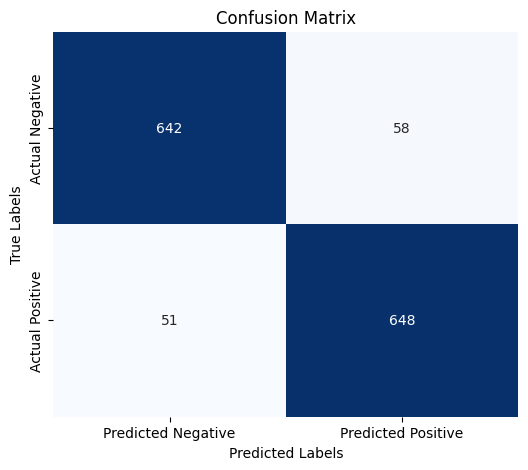

Evaluation Results:
Precision: 0.9178
Recall: 0.9270
F1 Score: 0.9224
Accuracy: 0.9221


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming eval_results['eval_confusion_matrix'] is a 2D array (confusion matrix)
conf_matrix = np.array(eval_results['eval_confusion_matrix'])

# Plot confusion matrix using seaborn heatmap for better presentation
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

# Printing the results
print("Evaluation Results:")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
